## Import Packages

In [33]:
import numpy as np
import pandas as pd
from pytrends.request import TrendReq
from scipy import signal
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#from kneed import KneeLocator

### Extract confirmed case numbers for target countries

In [34]:
def extract_target_country_case(filename, country_list):
    covid_all = pd.read_csv(filename)
    covid_target = covid_all[covid_all['Country/Region'].isin(country_list)]
    covid_target = covid_target.drop(columns=['Province/State','Lat','Long'])
    # adding up the confirmed case numbers for countires with multiple rows
    for country in country_list:
        covid_multiple_rows = covid_target[covid_target['Country/Region']==country]
        if covid_multiple_rows.shape[0] > 1:
            covid_target = covid_target.drop(covid_multiple_rows.index)
            covid_single_row = covid_multiple_rows.groupby('Country/Region').sum().reset_index()
            covid_target = covid_target.append(covid_single_row).reset_index(drop=True)
        else:
            continue
    return(covid_target)

In [35]:
filename = "data/time_series_covid19_confirmed_global.csv"
country_dict = {'Taiwan*':'TW', 'Korea, South':'KR', 'Italy':'IT', 'Spain':'ES', 'Czechia':'CZ', 
                     'US':'US', 'Peru':'PE', 'Iran':'IR', 'Australia':'AU', 'South Africa':'ZA'}
country_list = list(country_dict.keys())
confirmed_case_target = extract_target_country_case(filename, country_list)

In [36]:
confirmed_case_target

Country/Region  1/22/2020  1/23/2020  1/24/2020  1/25/2020  1/26/2020  \
0        Czechia          0          0          0          0          0   
1           Iran          0          0          0          0          0   
2          Italy          0          0          0          0          0   
3   Korea, South          1          1          2          2          3   
4           Peru          0          0          0          0          0   
5   South Africa          0          0          0          0          0   
6          Spain          0          0          0          0          0   
7        Taiwan*          1          1          3          3          4   
8             US          1          1          2          2          5   
9      Australia          0          0          0          0          4   

   1/27/2020  1/28/2020  1/29/2020  1/30/2020  ...  4/15/2020  4/16/2020  \
0          0          0          0          0  ...       6216       6433   
1          0          0          0          0  ...      76389      77995   
2          0          0          0          0  ...     165155     168941   
3          4          4          4          4  ...      10591      10613   
4          0          0          0          0  ...      11475      12491   
5          0          0          0          0  ...       2506       2605   
6          0          0          0          0  ...     177644     184948   
7          5          8          8          9  ...        395        395   
8          5          5          5          5  ...     636350     667592   
9          5          5          6          9  ...       6440       6462   

   4/17/2020  4/18/2020  4/19/2020  4/20/2020  4/21/2020  4/22/2020  \
0       6549       6606       6746       6900       7033       7132   
1      79494      80868      82211      83505      84802      85996   
2     172434     175925     178972     181228     183957     187327   
3      10635      10653      10661      10674      10683      10694   
4      13489      14420      15628      16325      17837      19250   
5       2783       3034       3158       3300       3465       3635   
6     190839     191726     198674     200210     204178     208389   
7        395        398        420        422        425        426   
8     699706     732197     758809     784326     811865     840351   
9       6522       6568       6610       6623       6645       6652   

   4/23/2020  4/24/2020  
0       7187       7273  
1      87026      88194  
2     189973     192994  
3      10708      10718  
4      20914      21648  
5       3953       4220  
6     213024     219764  
7        427        428  
8     869170     905358  
9       6662       6677  

[10 rows x 95 columns]

### Transpose confirmed_case_target dataframe

In [37]:
df_country = pd.DataFrame(country_dict.items(), columns=['Name','Code'])
confirmed_case_target = pd.merge(confirmed_case_target, df_country, how='left', left_on='Country/Region', right_on='Name')
confirmed_case_tr = confirmed_case_target.transpose()

# set country code as the column names of the transposed dataframe
confirmed_case_tr.columns = confirmed_case_tr.loc['Code']
confirmed_case_tr = confirmed_case_tr.drop(['Country/Region','Name','Code'])

# set date as the index of the transposed dataframe
confirmed_case_tr.index = pd.to_datetime(confirmed_case_tr.index)

In [38]:
confirmed_case_tr.tail()

Code          CZ     IR      IT     KR     PE    ZA      ES   TW      US    AU
2020-04-20  6900  83505  181228  10674  16325  3300  200210  422  784326  6623
2020-04-21  7033  84802  183957  10683  17837  3465  204178  425  811865  6645
2020-04-22  7132  85996  187327  10694  19250  3635  208389  426  840351  6652
2020-04-23  7187  87026  189973  10708  20914  3953  213024  427  869170  6662
2020-04-24  7273  88194  192994  10718  21648  4220  219764  428  905358  6677

### Extract Google Trends of single(multiple) keyword(s) for each target country

In [7]:
# (old)only for extracting keywords together
def extract_google_trends(timeframe, keywords_dict):
    timeframe = timeframe[0]+" "+timeframe[1]
    pytrend = TrendReq(hl='en-US', tz=360)
    result_dict = {}
    for key in list(keywords_dict.keys())[:-1]:
        pytrend.build_payload(kw_list=keywords_dict[key], cat=0, timeframe=timeframe, geo=key)
        result_local = pytrend.interest_over_time().drop(columns=['isPartial'])
        if key == 'US':
            result = result_local
        else:
            result_local.columns = [keyword+"(local)" for keyword in keywords_dict['common']]
            pytrend.build_payload(kw_list=keywords_dict['common'], cat=0, timeframe=timeframe, geo=key)
            result_common = pytrend.interest_over_time().drop(columns=['isPartial'])
            result = pd.concat([result_local, result_common], axis=1)
        result['date'] = result.index.strftime("%Y/%m/%d")
        result_dict[key] = result
    return(result_dict)

In [39]:
# extract Google Trends of single(multiple) keyword(s) for each target country
def extract_google_trends(timeframe, keywords_dict, single_search=True):
    timeframe = timeframe[0]+" "+timeframe[1]
    pytrend = TrendReq(hl='en-US', tz=360)
    result_dict = {}
    for key in list(keywords_dict.keys())[:-1]:
        # extract Google Trends of single keyword for each target country
        if single_search:
            result = pd.DataFrame()
            for word in keywords_dict[key]:
                pytrend.build_payload(kw_list=[word], cat=0, timeframe=timeframe, geo=key)
                if pytrend.interest_over_time().empty:
                        result = pd.concat([result, pd.DataFrame(0, index=result.index, columns=[word])], axis=1)
                result = pd.concat([result, pytrend.interest_over_time()], axis=1)
            # extract Google Trends of English keywords for each target country
            if key != 'US':
                result = result.drop(columns=['isPartial'])
                result.columns = [keyword+"(local)" for keyword in keywords_dict['common']]
                for word in keywords_dict['common']:
                    pytrend.build_payload(kw_list=[word], cat=0, timeframe=timeframe, geo=key)
                    result = pd.concat([result, pytrend.interest_over_time()], axis=1)
            result = result.drop(columns=['isPartial'])
            
        # extract Google Trends of multiple keywords for each target country
        else:
            pytrend.build_payload(kw_list=keywords_dict[key], cat=0, timeframe=timeframe, geo=key)
            result_local = pytrend.interest_over_time().drop(columns=['isPartial'])
            if key == 'US':
                result = result_local
            # extract Google Trends of English keywords for each target country
            else:
                result_local.columns = [keyword+"(local)" for keyword in keywords_dict['common']]
                pytrend.build_payload(kw_list=keywords_dict['common'], cat=0, timeframe=timeframe, geo=key)
                result_common = pytrend.interest_over_time().drop(columns=['isPartial'])
                result = pd.concat([result_local, result_common], axis=1)        
        result_dict[key] = result
    return(result_dict)

In [41]:
timeframe = ('2020-01-01', confirmed_case_tr.index[-1].strftime('%Y-%m-%d'))
keywords_dict = {'TW':['武漢', '冠狀病毒', '武漢肺炎', '肺炎', '新冠肺炎'],
                 'KR':['우한', '코로나바이러스', '우한 폐렴', '폐렴', '신종 코로나바이러스'],
                 'IT': ['Wuhan', 'coronavirus', 'Polmonite di Wuhan', 'Polmonite', 'covid'],
                 'ES': ['Wuhan', 'coronavirus', 'neumonía de Wuhan', 'neumonía', 'covid'],
                 'CZ': ['Wu-chan', 'koronavirus', 'wuchanský koronavirus', 'zápal plic', 'covid'],
                 'US':['Wuhan', 'coronavirus', 'Wuhan coronavirus', 'pneumonia', 'covid'],
                 'PE':['Wuhan', 'coronavirus', 'neumonía de Wuhan', 'neumonía', 'covid'],
                 'IR':['ووهان','کروناویروس','ووهان کروناویروس','سینه‌پهلو','کووید'],
                 'AU':['Wuhan', 'coronavirus', 'Wuhan coronavirus', 'pneumonia','covid'],
                 'ZA':['Wuhan', 'coronavirus', 'Wuhan Koronavirus', 'Longontsteking','covid'],
                 'common':['Wuhan', 'coronavirus', 'Wuhan coronavirus', 'pneumonia', 'covid']}

single_google_trends_dict = extract_google_trends(timeframe, keywords_dict)
multi_google_trends_dict = extract_google_trends(timeframe, keywords_dict, single_search=False)

In [42]:
single_google_trends_dict['ES'].head()

Wuhan(local)  coronavirus(local)  Wuhan coronavirus(local)  \
date                                                                     
2020-01-01             0                   0                         0   
2020-01-02             0                   0                         0   
2020-01-03             1                   0                         0   
2020-01-04             1                   0                         0   
2020-01-05             1                   0                         0   

            pneumonia(local)  covid(local)  Wuhan  coronavirus  \
date                                                             
2020-01-01                12             0      0            0   
2020-01-02                13             0      0            0   
2020-01-03                19             0      1            0   
2020-01-04                20             0      1            0   
2020-01-05                22             0      1            0   

            Wuhan coronavirus  pneumonia  covid  
date                                             
2020-01-01                  0          0      0  
2020-01-02                  0         25      0  
2020-01-03                  0         13      0  
2020-01-04                  0         20      0  
2020-01-05                  0          0      0

### Merge confirmed case dataframe to Google Trends query results
* Reference:
https://thispointer.com/pandas-how-to-merge-dataframes-by-index-using-dataframe-merge-part-3/

In [43]:
for dictionary in [single_google_trends_dict, multi_google_trends_dict]:
    for key in dictionary:
        df_merged = pd.merge(dictionary[key], confirmed_case_tr[key], how='left', left_index=True, right_index=True)
        df_merged[key] = df_merged[key].fillna(0)
        dictionary[key] = df_merged.rename(columns={key:"Confirmed Case"})
        
#         # compute the daily increased cases as "Daily Case" column
#         daily_case = df_merged[key]-df_merged[key].shift(1)
#         df_merged = pd.concat([df_merged, daily_case.rename('Daily Case')], axis=1)

#         # compute the change in daily increased cases as "Daily Case Change" column
#         daily_case_change = df_merged[key]-2*df_merged[key].shift(1)+df_merged[key].shift(2)
#         df_merged = pd.concat([df_merged, daily_case_change.rename('Daily Case Change')], axis=1)

In [44]:
multi_google_trends_dict['TW'].tail()

Wuhan(local)  coronavirus(local)  Wuhan coronavirus(local)  \
date                                                                     
2020-04-20            18                   1                         0   
2020-04-21            16                   1                         0   
2020-04-22            14                   1                         0   
2020-04-23            13                   1                         0   
2020-04-24            10                   1                         0   

            pneumonia(local)  covid(local)  Wuhan  coronavirus  \
date                                                             
2020-04-20                29             0      1           24   
2020-04-21                25             0      1           26   
2020-04-22                22             0      1           23   
2020-04-23                17             0      0           22   
2020-04-24                16             0      1           20   

            Wuhan coronavirus  pneumonia  covid  Confirmed Case  
date                                                             
2020-04-20                  0          1     13             422  
2020-04-21                  0          0     13             425  
2020-04-22                  0          1     12             426  
2020-04-23                  0          0     14             427  
2020-04-24                  0          1      8             428

### Find the date where the number of confirmed case becomes notable in each country
* Reference:
#### (1) https://plotly.com/python/smoothing/
#### (2) https://pypi.org/project/kneed/#input-data

In [45]:
def find_notable_date(confirmed_case):
    # smooth the confirmed case curve
    confirmed_case_smooth = pd.Series(signal.savgol_filter(confirmed_case, 15, 3), index=confirmed_case.index)
    
    # find the notable date with the maximum change in daily increased case
    daily_case_change_smooth = confirmed_case_smooth-2*confirmed_case_smooth.shift(1)+confirmed_case_smooth.shift(2)
    notable_date = daily_case_change_smooth.idxmax().strftime("%Y-%m-%d")
    
#     # find the notable date, which is the day after the confirmed case curve reaches elbow point using kneed.KneeLocator package
#     x, y = confirmed_case_smooth.reset_index().index, confirmed_case_smooth
#     kn = KneeLocator(x, y, curve='convex', direction='increasing', online=True)
#     notable_date_2 = confirmed_case_smooth.index[kn.knee+1].strftime('%Y-%m-%d')
    return(notable_date)

In [46]:
for key in multi_google_trends_dict:
    confirmed_case = multi_google_trends_dict[key]['Confirmed Case']
    notable_date = find_notable_date(confirmed_case)
    index = datetime.strptime(notable_date,'%Y-%m-%d')
    print("Notable date of", key, ": ", notable_date)
    print(confirmed_case[index-timedelta(5):index],"\n")
    
#     notable_date_1, notable_date_2 = find_notable_date(confirmed_case)
#     index1 = datetime.strptime(notable_date_1,'%Y-%m-%d')
#     index2 = datetime.strptime(notable_date_2,'%Y-%m-%d')
#     print(key+": ",notable_date_1, notable_date_2)
#     if index1 > index2:
#         print(confirmed_case[index2-timedelta(1):index1],"\n")
#     else:
#         print(confirmed_case[index1-timedelta(1):index2],"\n")

Notable date of TW :  2020-03-18
date
2020-03-13     50
2020-03-14     53
2020-03-15     59
2020-03-16     67
2020-03-17     77
2020-03-18    100
Name: Confirmed Case, dtype: int64 

Notable date of KR :  2020-02-26
date
2020-02-21     204
2020-02-22     433
2020-02-23     602
2020-02-24     833
2020-02-25     977
2020-02-26    1261
Name: Confirmed Case, dtype: int64 

Notable date of IT :  2020-03-16
date
2020-03-11    12462
2020-03-12    12462
2020-03-13    17660
2020-03-14    21157
2020-03-15    24747
2020-03-16    27980
Name: Confirmed Case, dtype: int64 

Notable date of ES :  2020-03-21
date
2020-03-16     9942
2020-03-17    11748
2020-03-18    13910
2020-03-19    17963
2020-03-20    20410
2020-03-21    25374
Name: Confirmed Case, dtype: int64 

Notable date of CZ :  2020-03-22
date
2020-03-17     396
2020-03-18     464
2020-03-19     694
2020-03-20     833
2020-03-21     995
2020-03-22    1120
Name: Confirmed Case, dtype: int64 

Notable date of US :  2020-03-29
date
2020-03-24 

### Plot Google Trends query results (keywords are extrated together) vs. confirmed case number over time
* Reference:
#### (1) https://seaborn.pydata.org/tutorial/color_palettes.html
#### (2) https://matplotlib.org/3.2.1/gallery/shapes_and_collections/fancybox_demo.html
#### (3) https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/

In [ ]:
# old
def plot_GT_case_trends(notable_rate, popularity, country, local=True):
    t = popularity.index.values
    confirmed_case = popularity['Confirmed Case']
    notable_date_1 = popularity['Daily Case Change(Smoothed)'].idxmax().strftime("%Y-%m-%d")
    #confirmed_case_smooth = signal.savgol_filter(confirmed_case, 15, 3)
#    x,y = confirmed_case.reset_index().index, confirmed_case
#     kn_old = KneeLocator(x, y, curve='convex', direction='increasing')
#    kn = KneeLocator(x, y, curve='convex', direction='increasing', online=True)
#     notable_date_2 = confirmed_case.index[kn_old.knee].strftime('%Y-%m-%d')
#    notable_date_3 = confirmed_case.index[kn.knee].strftime('%Y-%m-%d')
    notable_date_4 = popularity[popularity['Daily Case'] > confirmed_case[-1]*notable_rate].index[0].strftime('%Y-%m-%d')
    
    if local: # when keywords are searched in local language
        popularity = popularity.iloc[:,:5]
        title = "Popularity of Google Search Queries(in local language) & Number of Confirmed Cases Over Time_"+country
    else: # when keywords are searched in English
        popularity = popularity.iloc[:,5:-5]
        title = "Popularity of Google Search Queries(in English) & Number of Confirmed Cases Over Time_"+country
   
    label = list(popularity.columns)
    color = sns.color_palette("husl", len(label))  
    
    # plot Google Trends query trend 
    fig, ax1 = plt.subplots(figsize=(25, 10))
    for i in range(len(label)):    
        ax1.plot(t, popularity.iloc[:,i], color=color[i], label=label[i], linewidth=3)
        
    ax2 = ax1.twinx()
    ax2.plot(t, confirmed_case, color='red', label='# of Confirmed Cases', linewidth=5)
    #ax2.plot(t, confirmed_case_smooth, color='green', linewidth=5)
    ax2.axvline(notable_date_1, color='black', ls='--', lw=3)
    ax2.axvline(notable_date_2, color='blue', ls='--', lw=3)
    #ax2.axvline(notable_date_3, color='green', ls='--', lw=3)
    ax2.axvline(notable_date_4, color='orange', ls='--', lw=3)

    date_form = mdates.DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.set_ylabel('Popularity of Query', fontsize=20)
    ax2.set_ylabel('Number of Confirmed Cases', fontsize=20, color='red')
    ax1.tick_params(axis='x', labelsize=15, labelrotation=45)
    ax1.tick_params(axis='y', labelsize=15)
    ax2.tick_params(axis='y', labelcolor='red', labelsize=15)
    ax1.grid(linewidth=0.5, color='gray')
    fig.legend(fontsize=15, loc=(0.07,0.7))
    plt.title(title, fontsize=25)
    plt.show()

In [47]:
def plot_GT_case_trends(popularity, country, local=True):
    t = popularity.index.values
    confirmed_case = popularity['Confirmed Case']
    notable_date = find_notable_date(confirmed_case)
    #confirmed_case_smooth = pd.Series(signal.savgol_filter(confirmed_case, 15, 3), index=confirmed_case.index)

    if local: # when keywords are searched in local language
        popularity = popularity.iloc[:,:5]
        title = "Popularity of Google Search Queries(in local language) & Number of Confirmed Cases Over Time_"+country
    else: # when keywords are searched in English
        popularity = popularity.iloc[:,5:-1]
        title = "Popularity of Google Search Queries(in English) & Number of Confirmed Cases Over Time_"+country
   
    label = list(popularity.columns)
    color = sns.color_palette("husl", len(label))  
    
    # plot the trend of Google Trends queries
    fig, ax1 = plt.subplots(figsize=(25, 10))
    for i in range(len(label)):    
        ax1.plot(t, popularity.iloc[:,i], color=color[i], label=label[i], linewidth=3)
        
    # plot the number of confirmed cases & the notable date
    ax2 = ax1.twinx()
    ax2.plot(t, confirmed_case, color='red', label='# of Confirmed Cases', linewidth=5)
    #ax2.plot(t, confirmed_case_smooth, color='green', linewidth=5)
    ax2.axvline(notable_date, color='blue', ls='--', lw=3)
    bbox = dict(fc='white',ec='blue',alpha=0.6)
    ax2.text(notable_date, confirmed_case[-1]*0.97, notable_date, color='blue', fontsize=20, bbox=bbox, ha='center')

    date_form = mdates.DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.set_ylabel('Popularity of Query', fontsize=20)
    ax2.set_ylabel('Number of Confirmed Cases', fontsize=20, color='red')
    ax1.tick_params(axis='x', labelsize=15, labelrotation=45)
    ax1.tick_params(axis='y', labelsize=15)
    ax2.tick_params(axis='y', labelcolor='red', labelsize=15)
    ax1.grid(linewidth=0.5, color='gray')
    fig.legend(fontsize=15, loc=(0.07,0.7))
    plt.title(title, fontsize=25)
    plt.show()

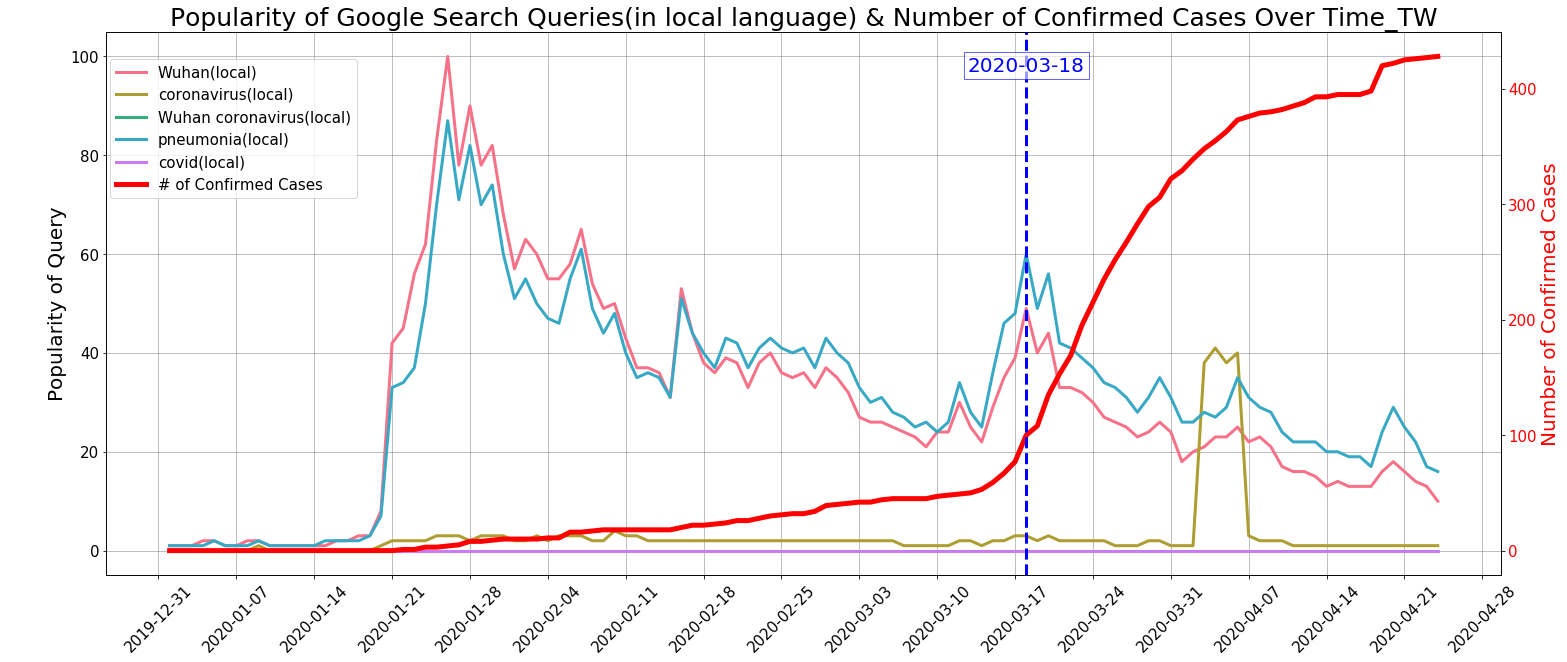

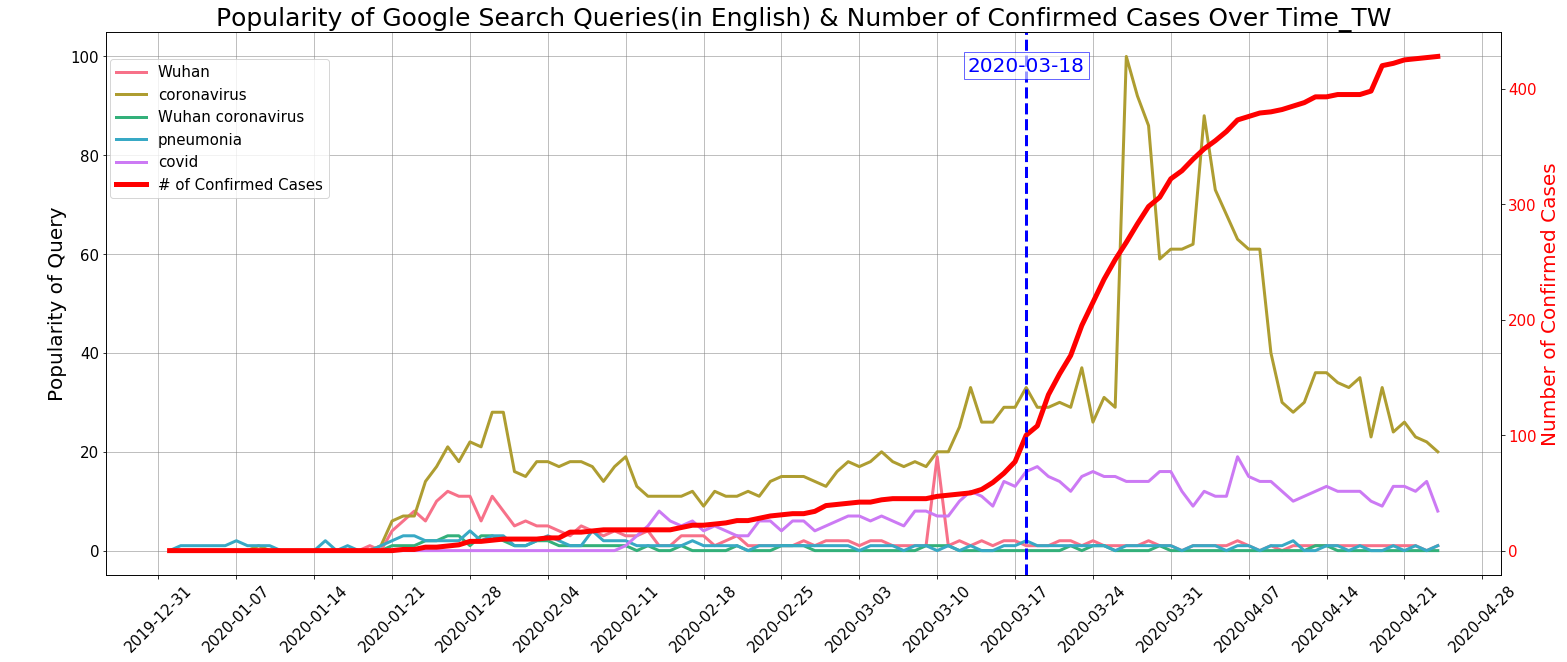

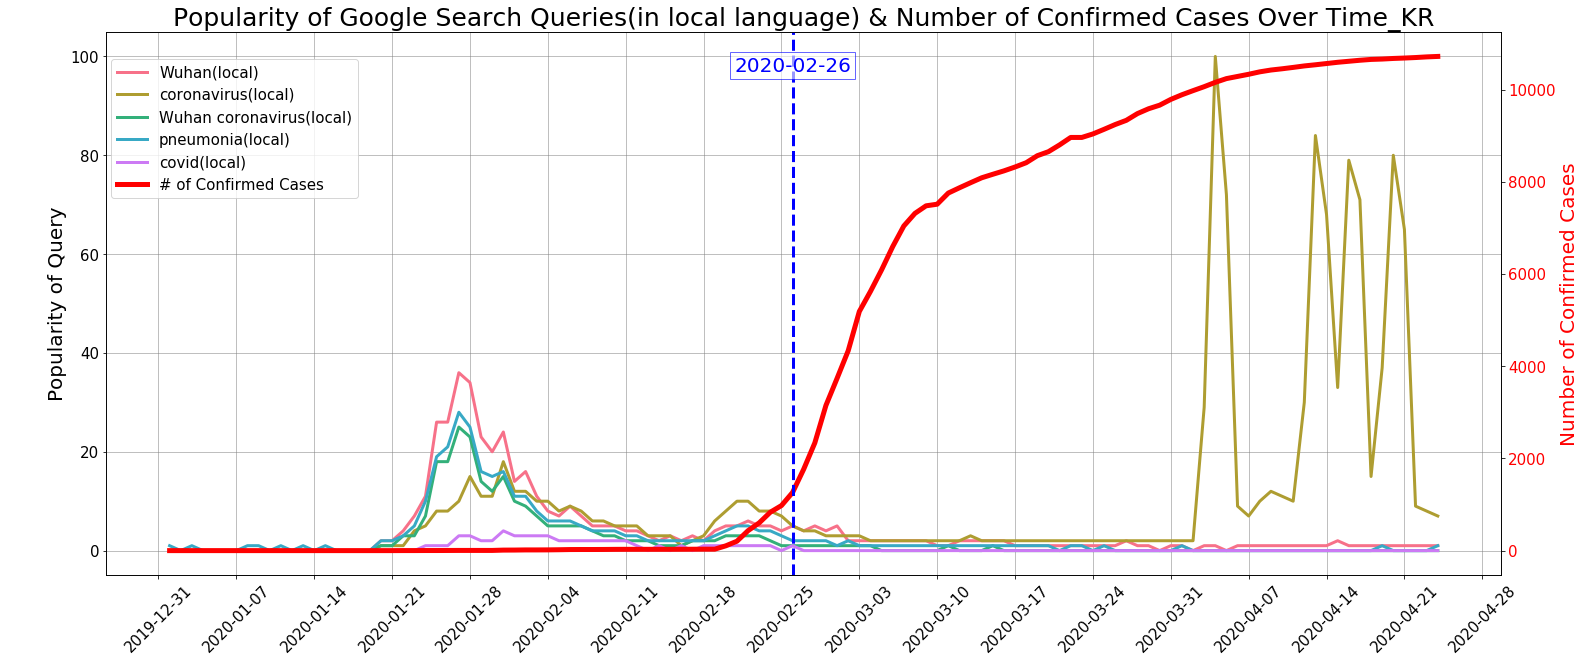

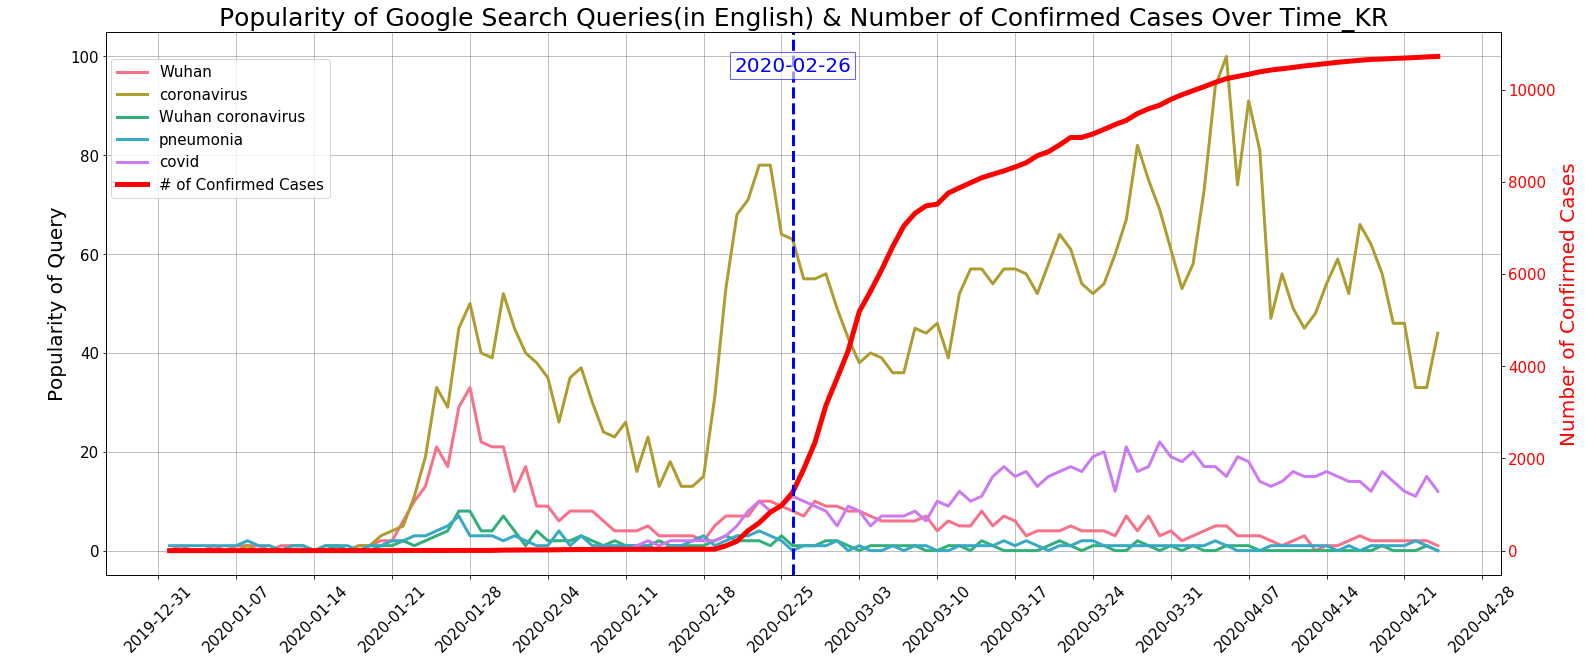

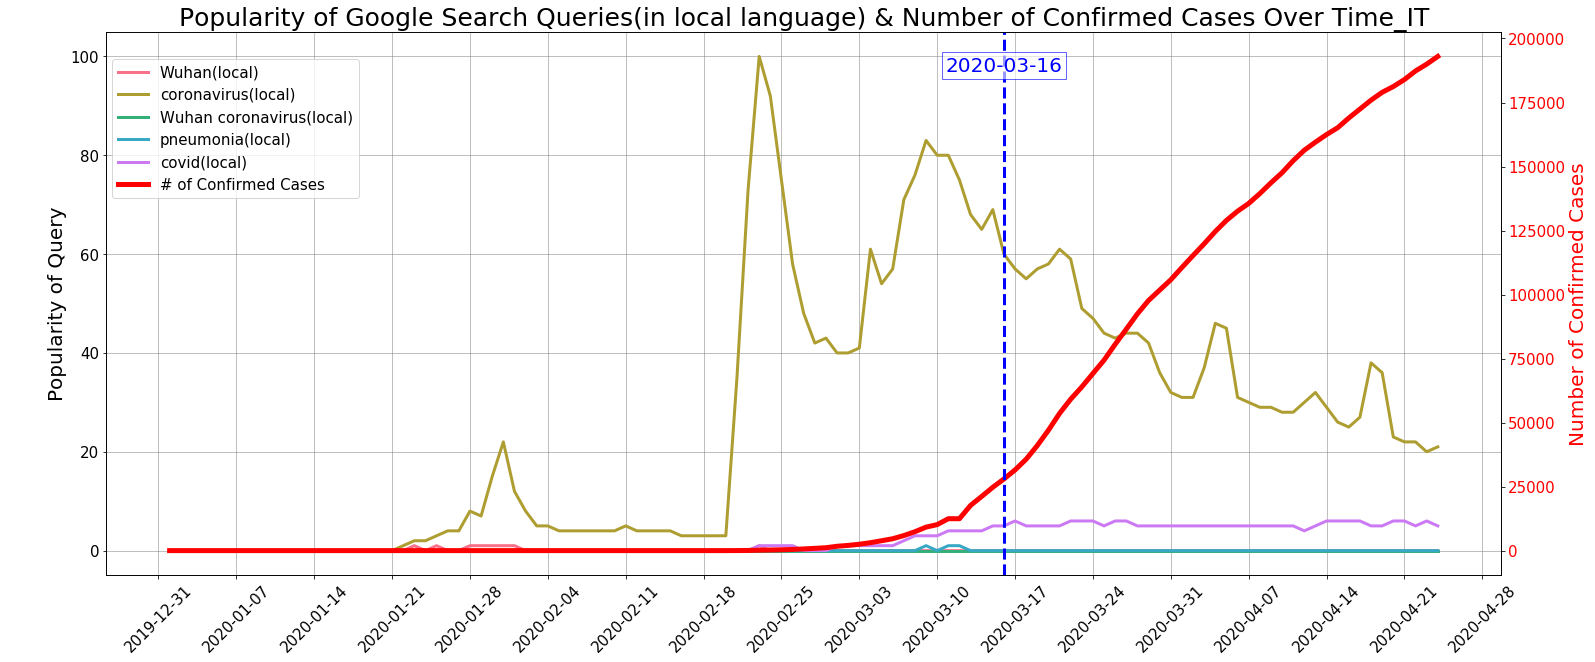

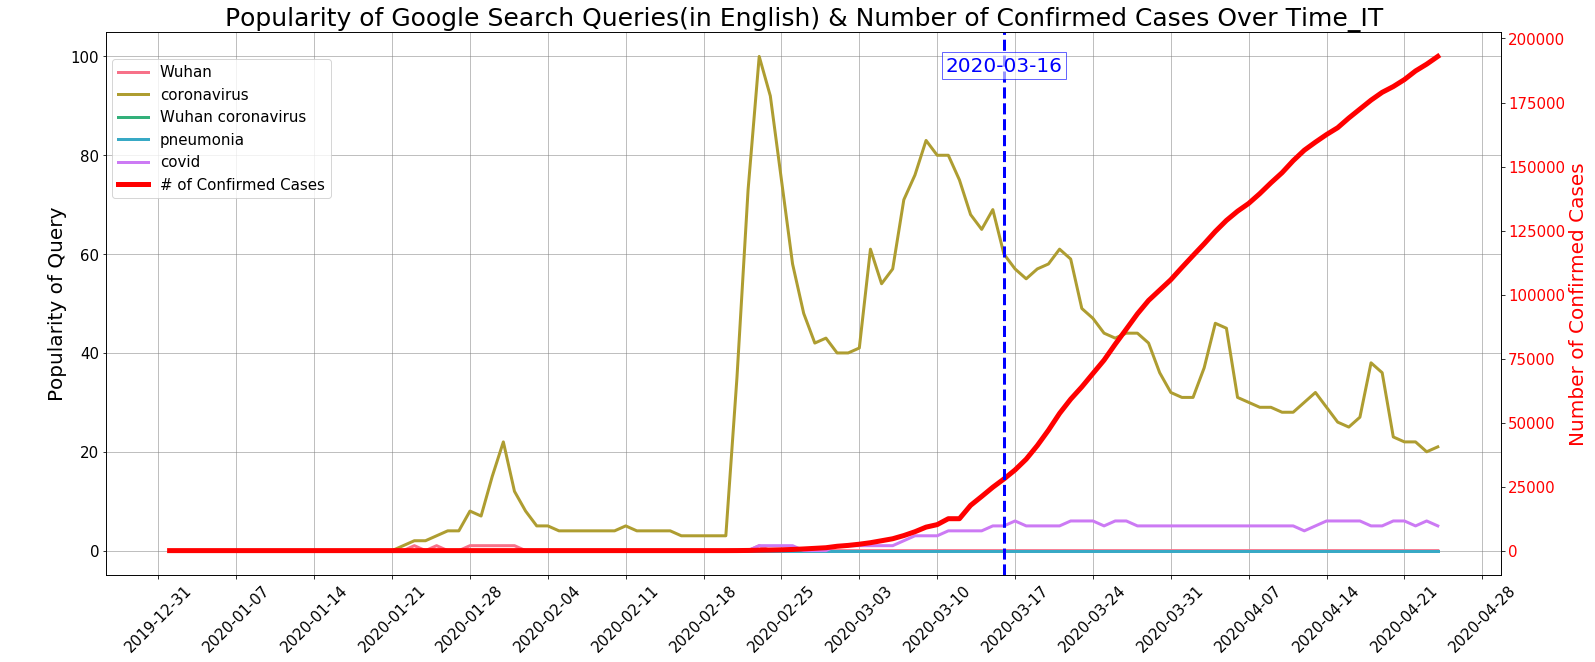

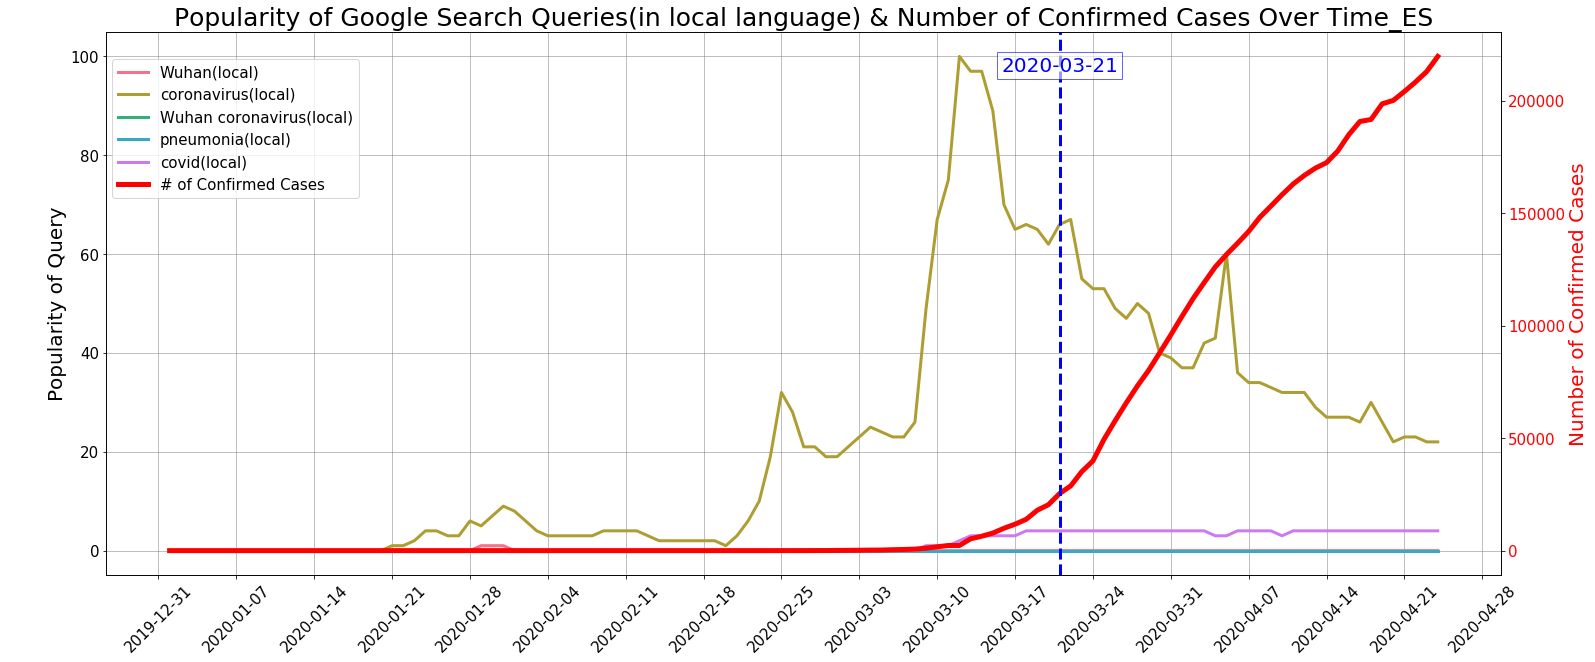

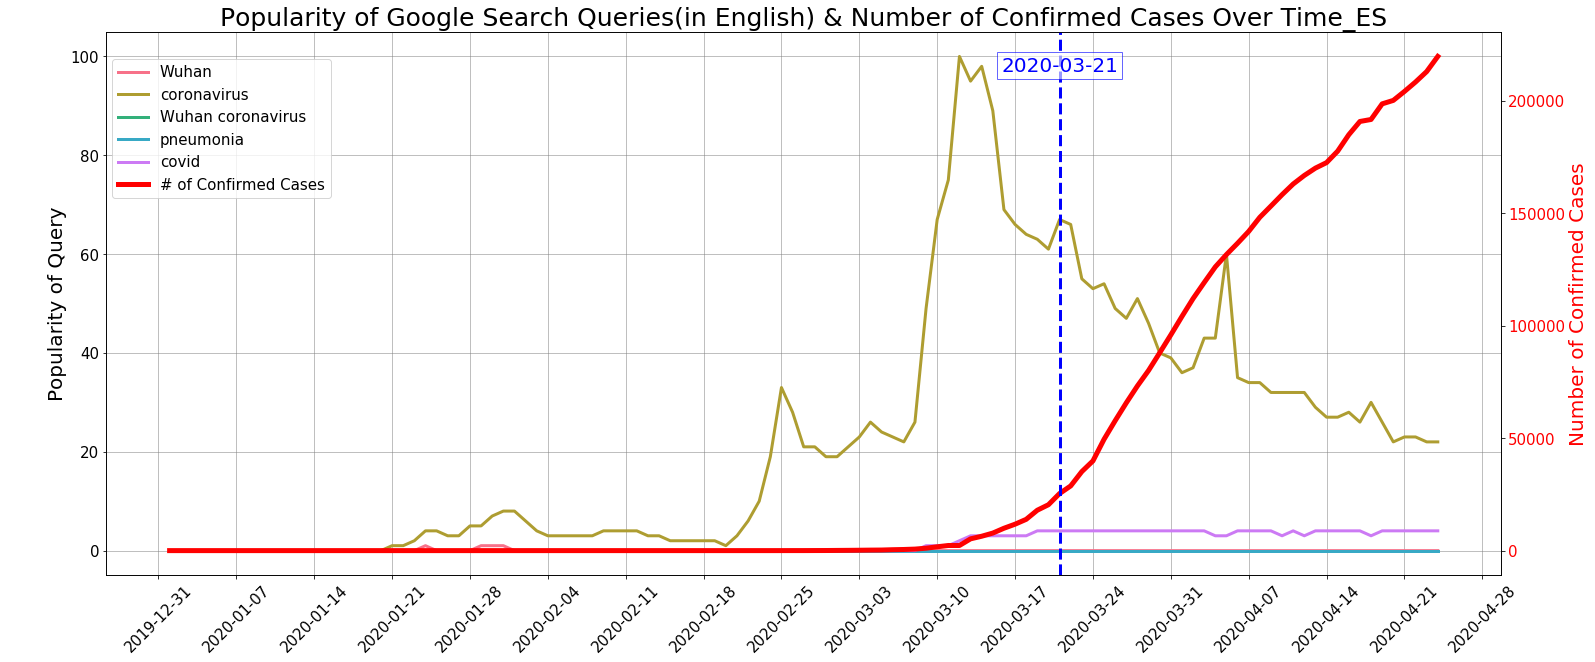

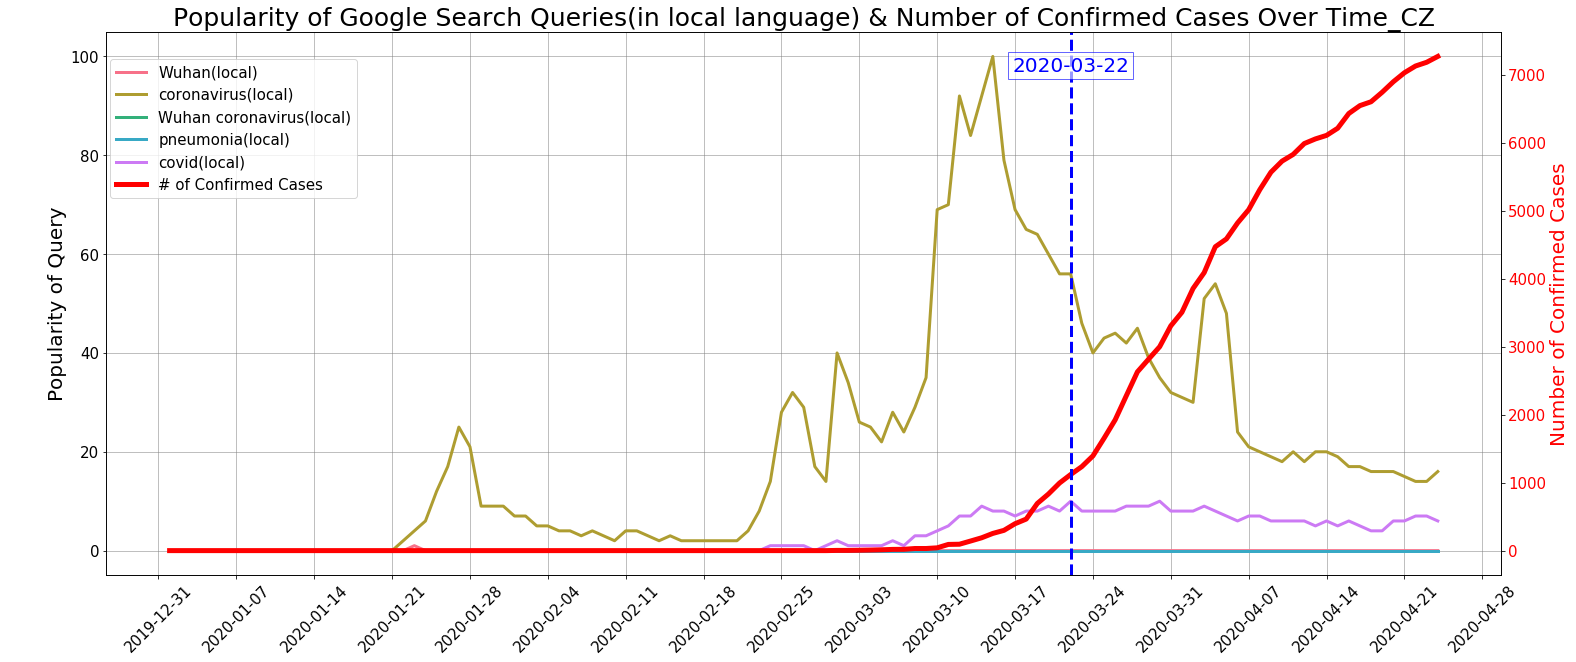

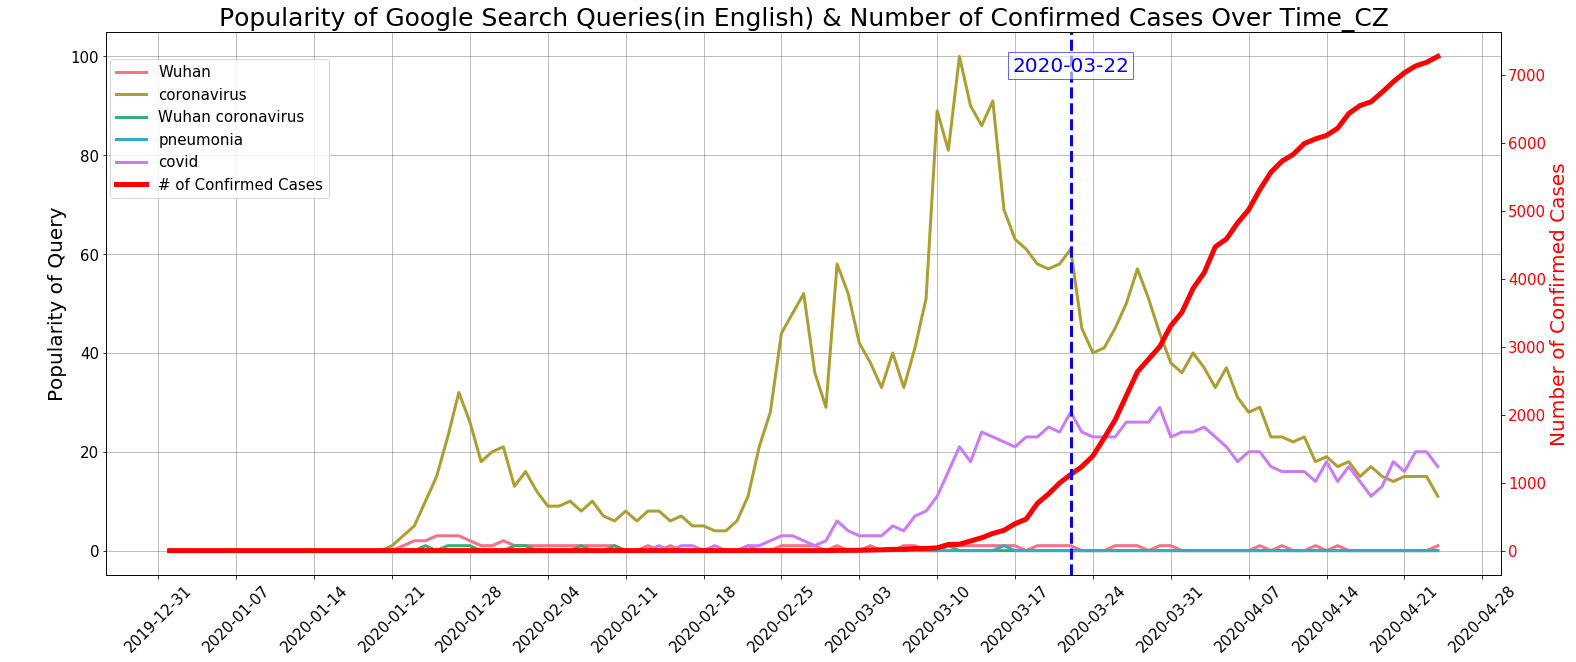

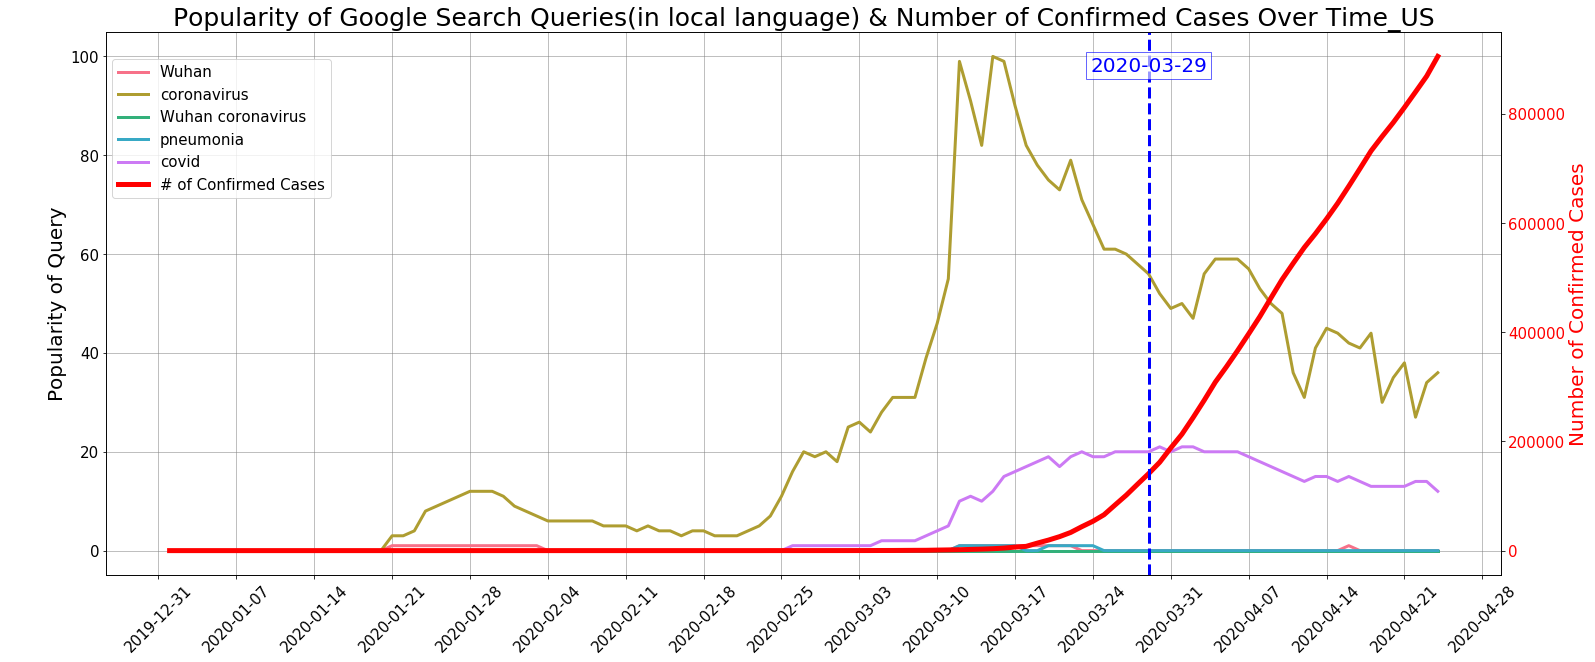

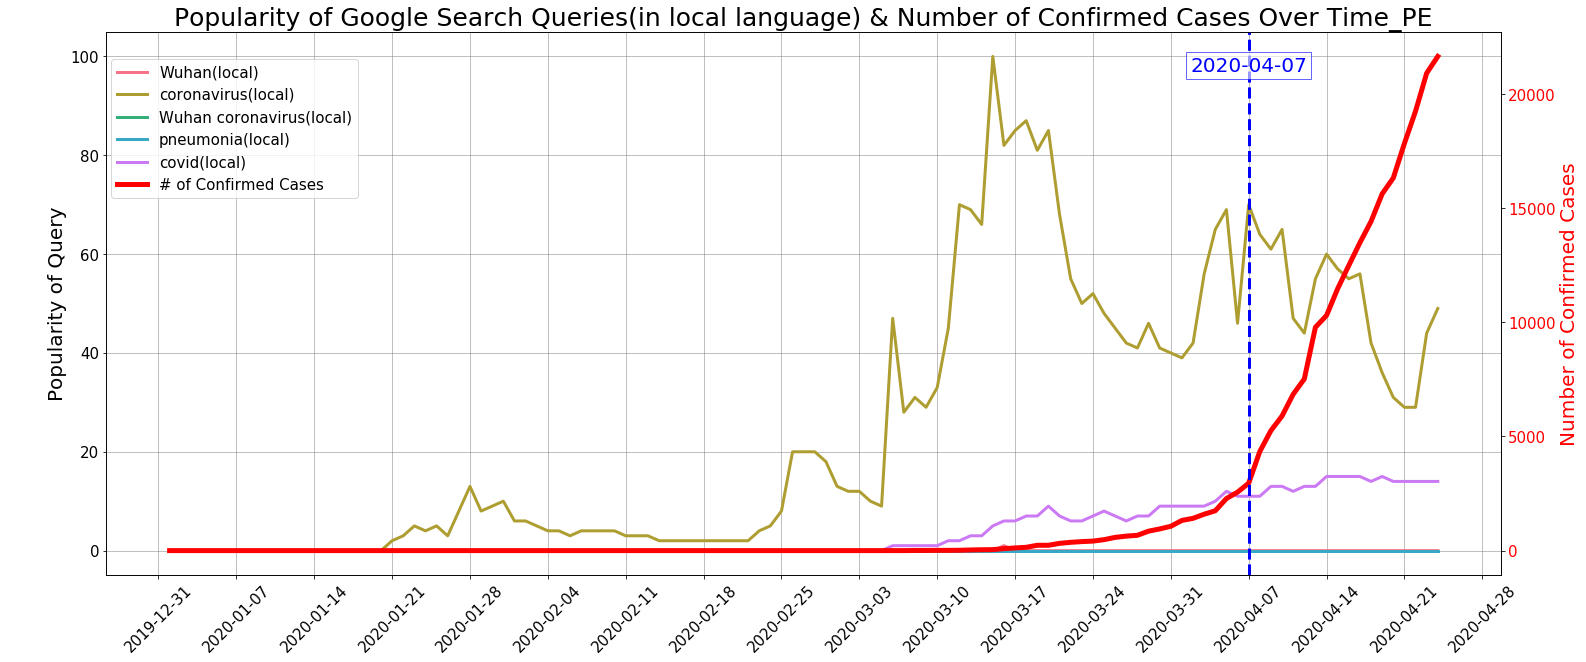

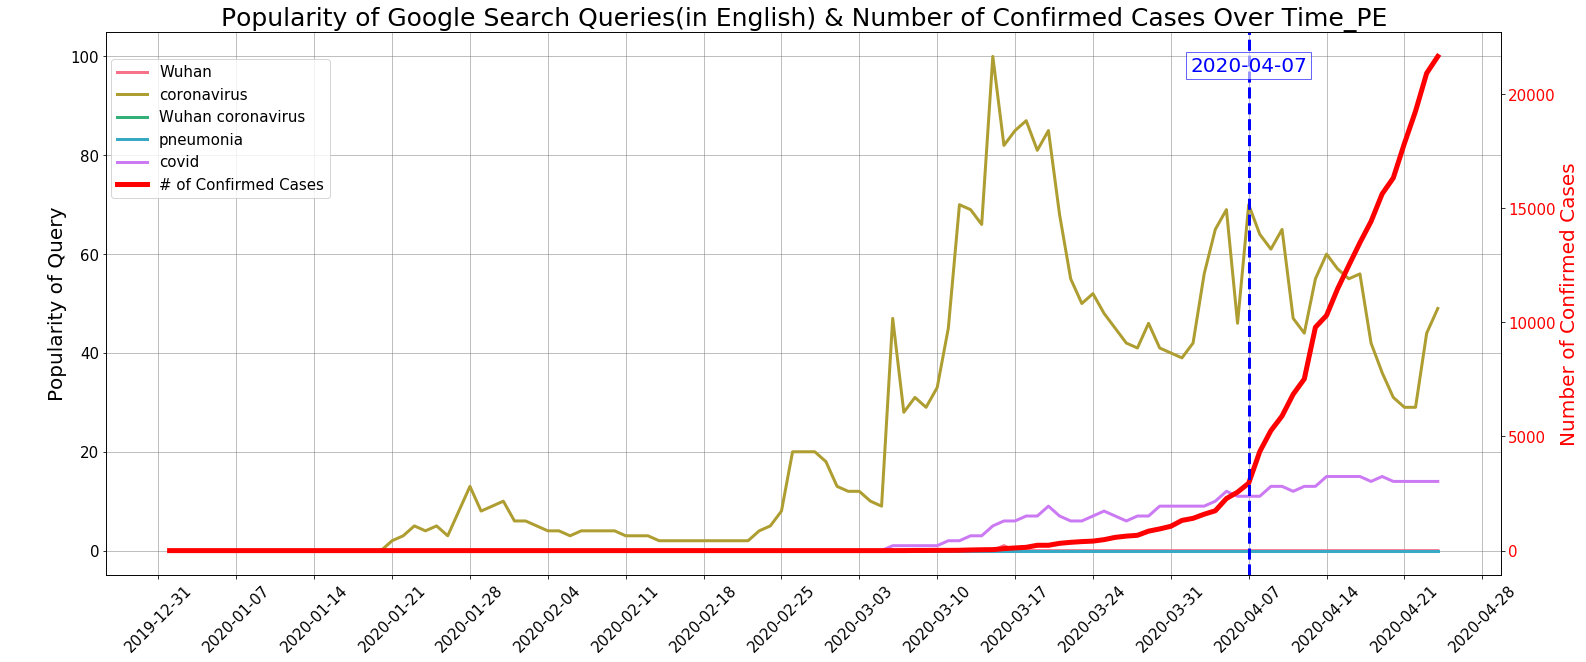

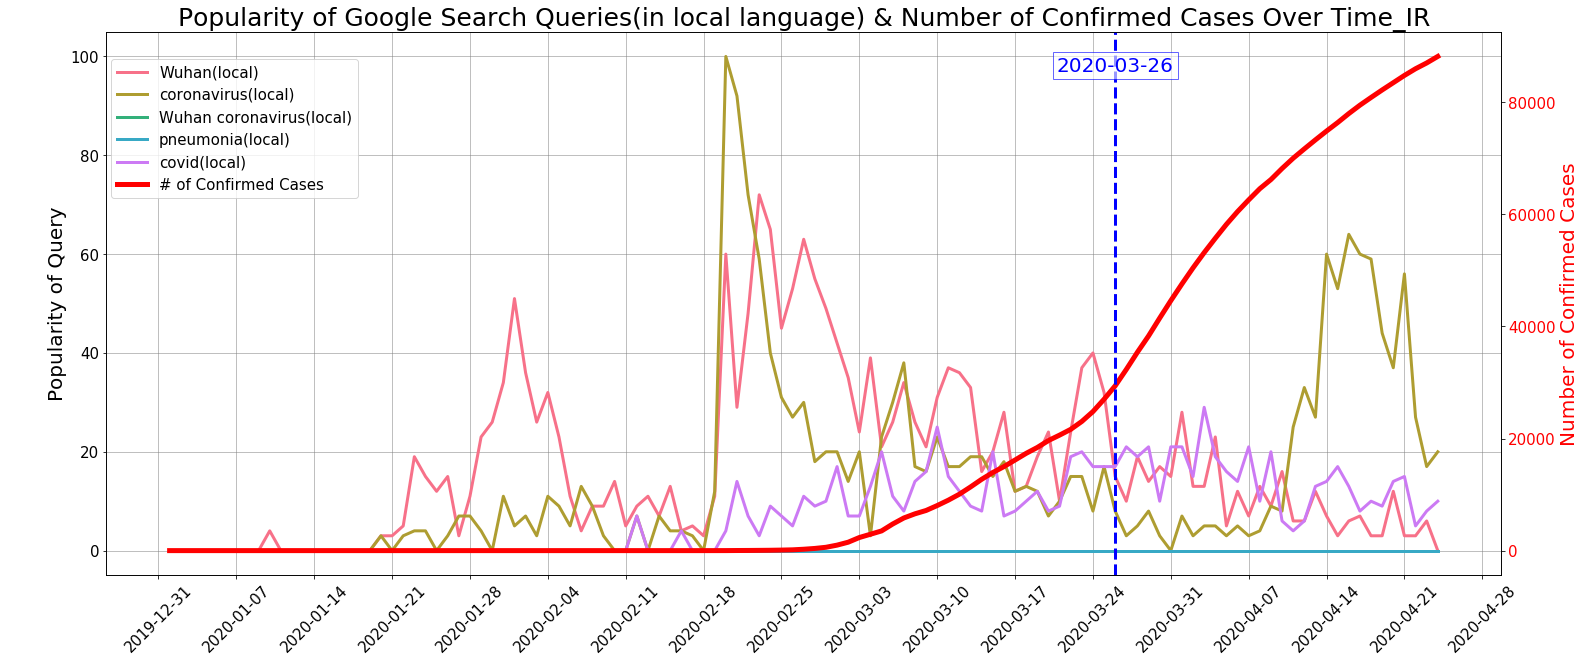

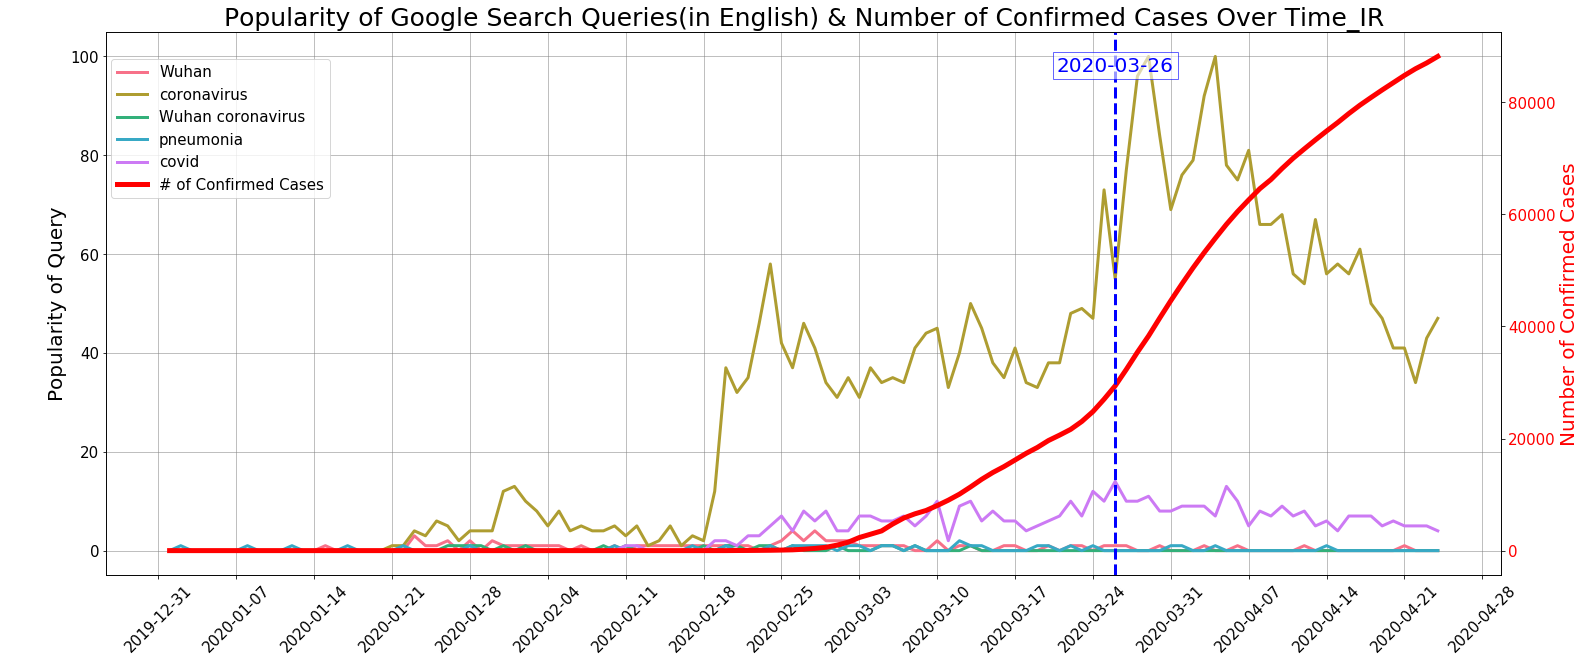

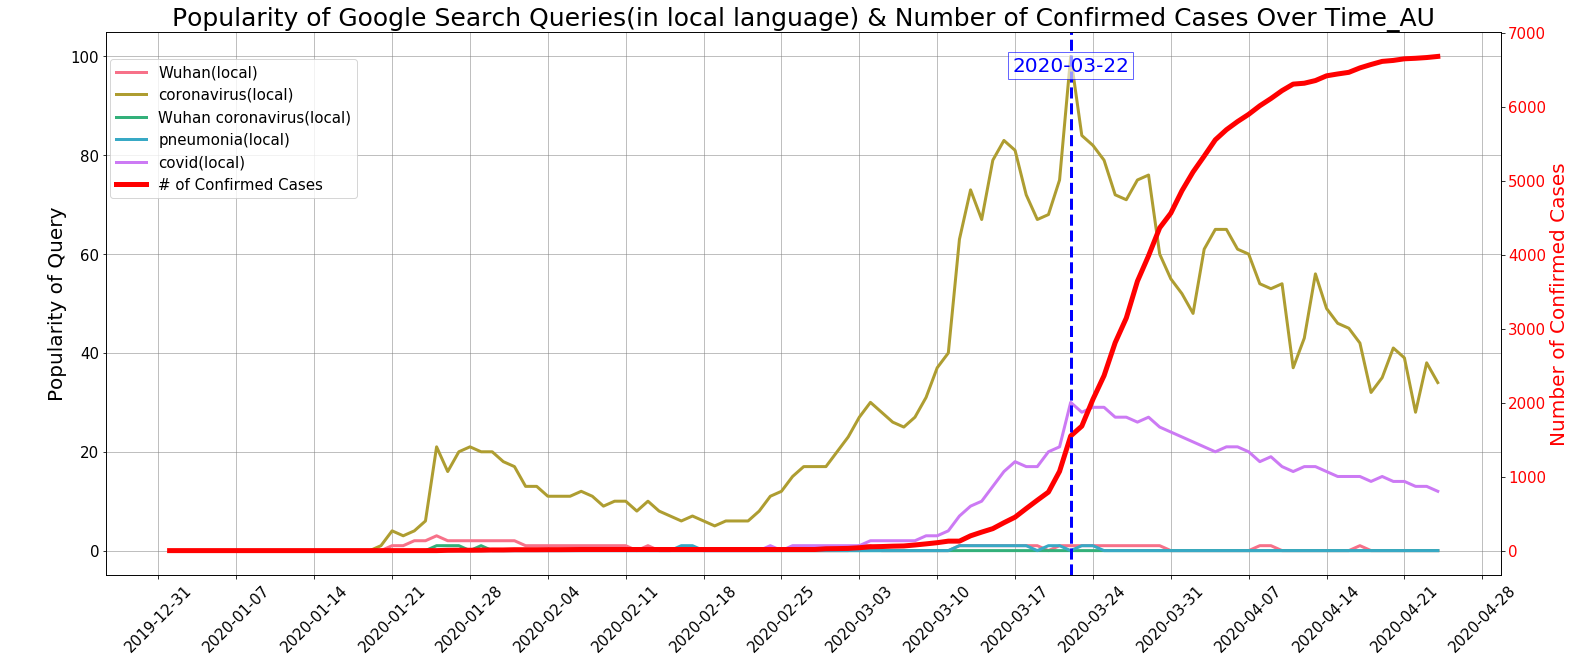

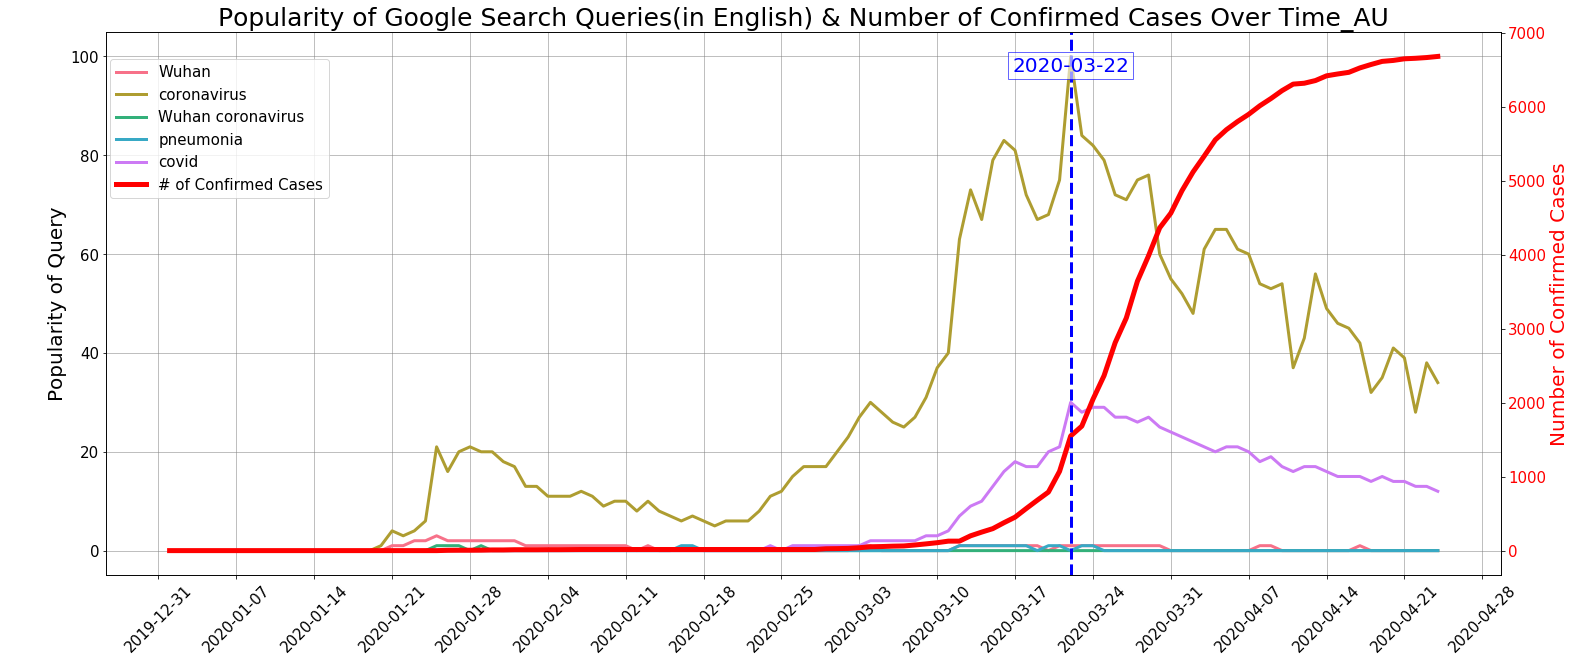

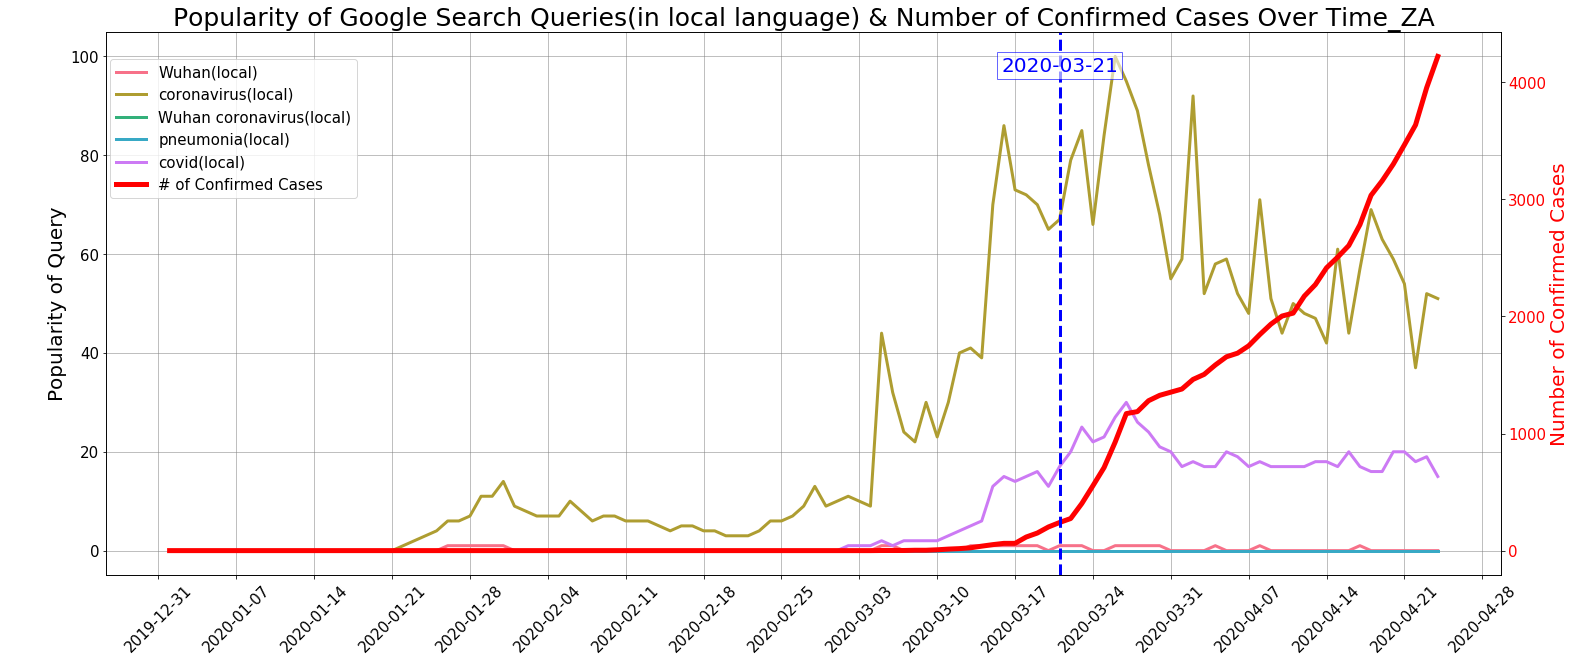

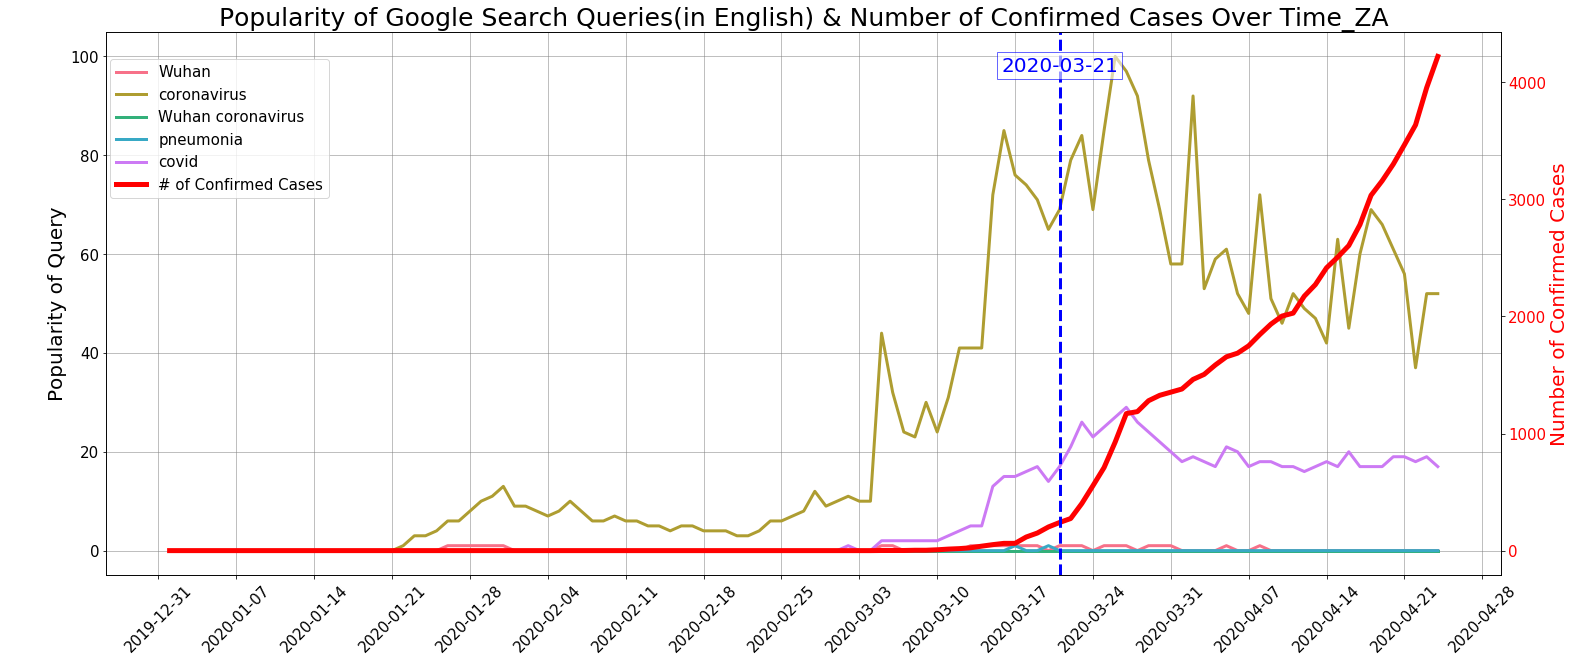

In [48]:
for key in multi_google_trends_dict:
    popularity = multi_google_trends_dict[key]
    plot_GT_case_trends(popularity, key)
    if key != 'US':
        plot_GT_case_trends(popularity, key, local=False)

### Actual searching results on Google Trends website:

<img src="GT_Results/TW_together(local).png">

<img src="GT_Results/KR_together(local).png">

<img src="GT_Results/IT_together(local).png">

<img src="GT_Results/US_together.png">

### Plot Google Trends query results (keywords are extrated individually) vs. confirmed case number over time

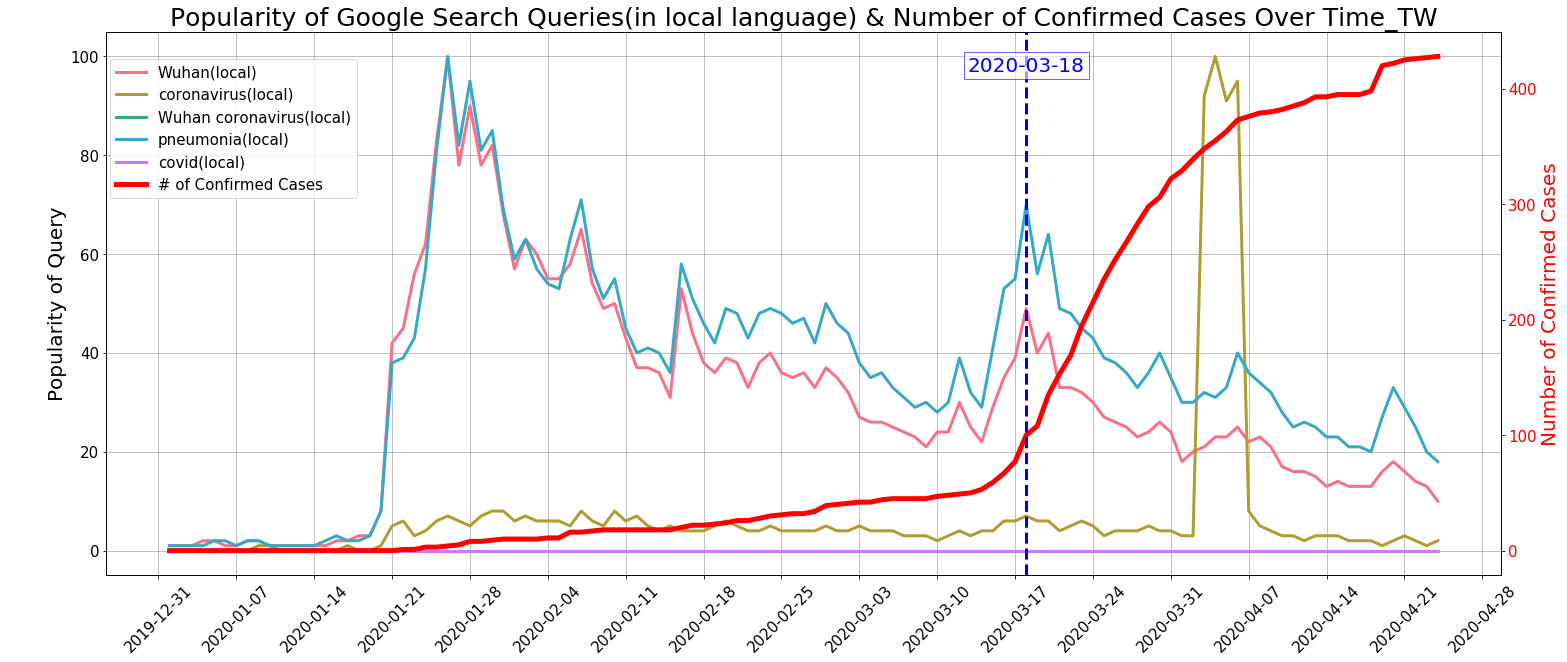

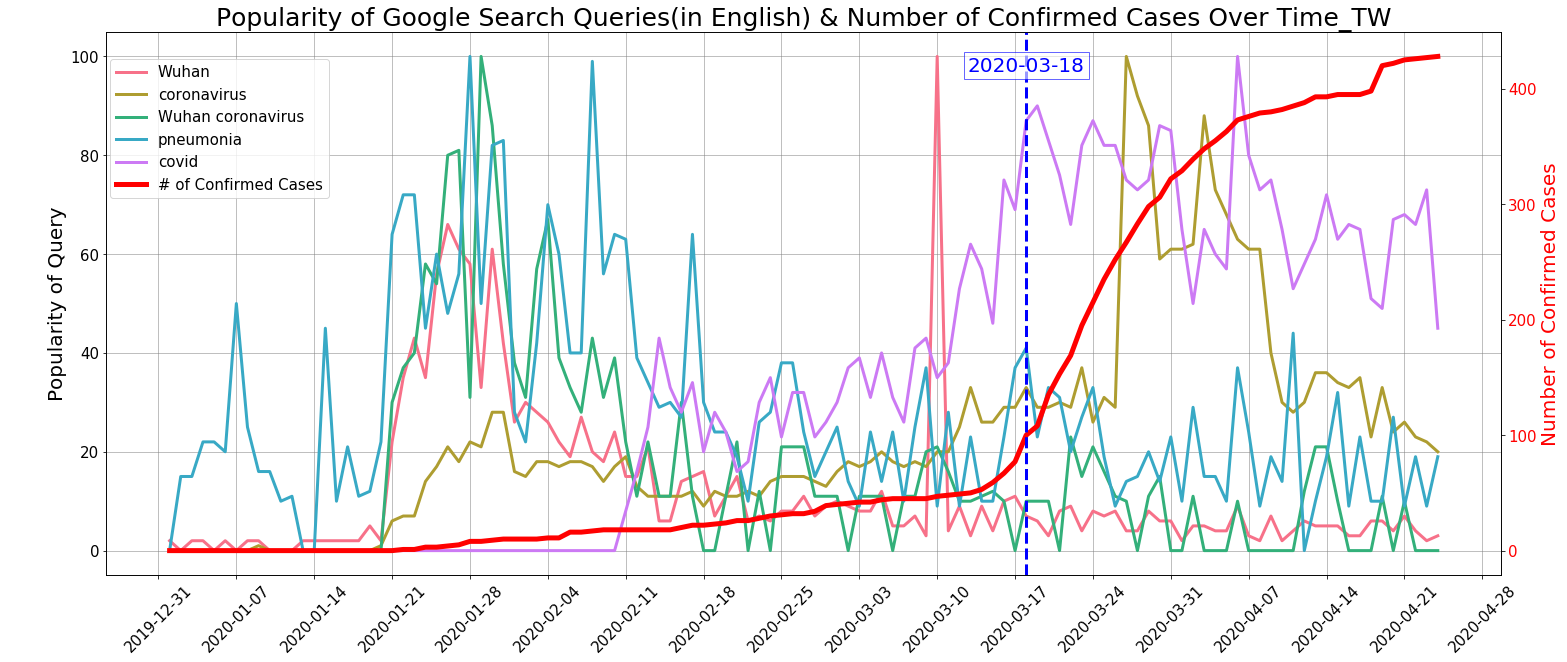

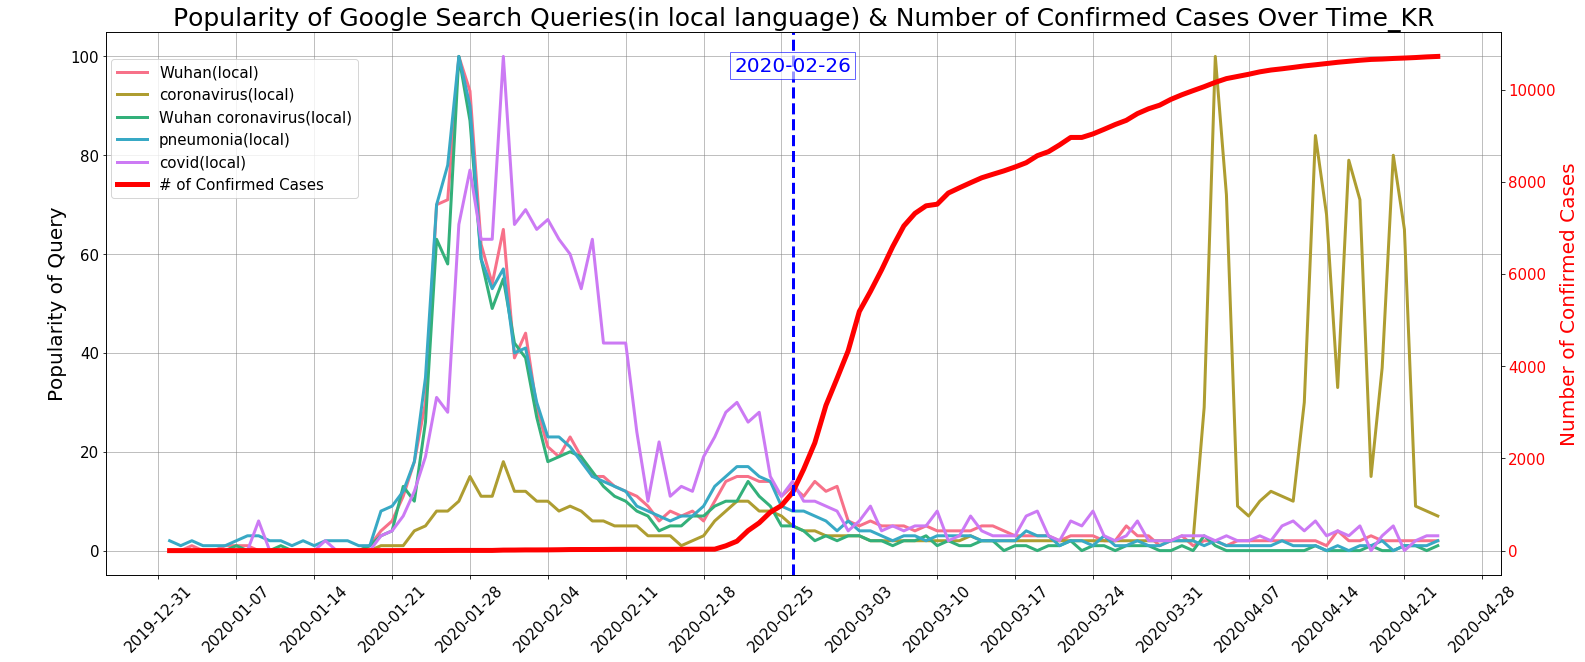

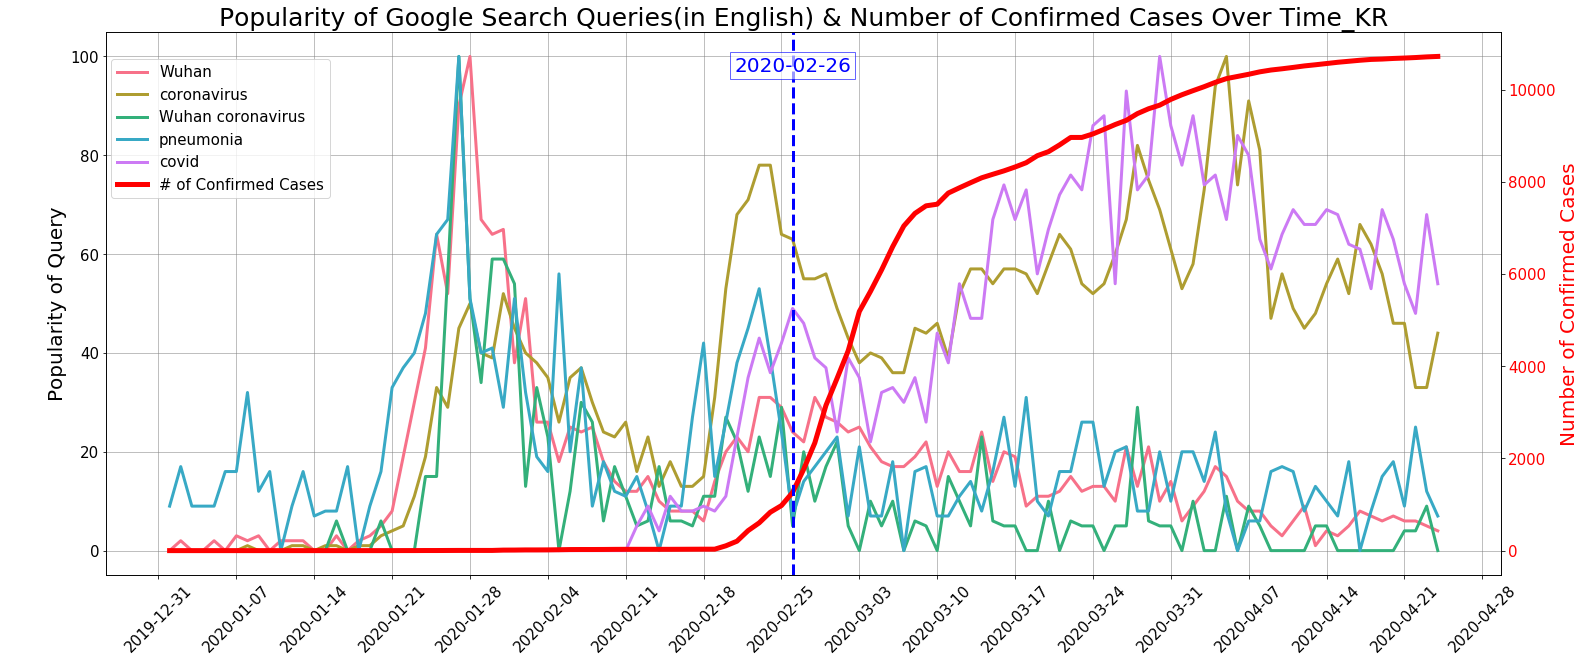

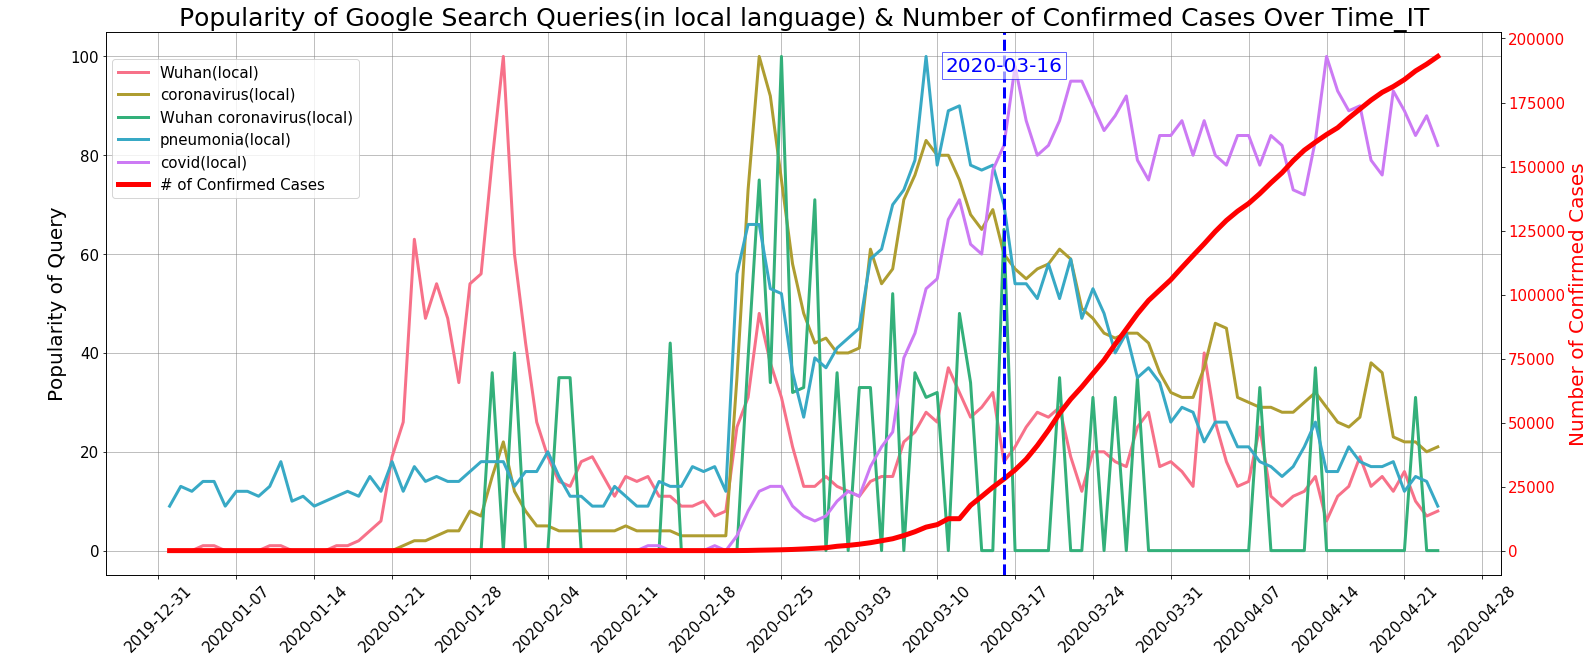

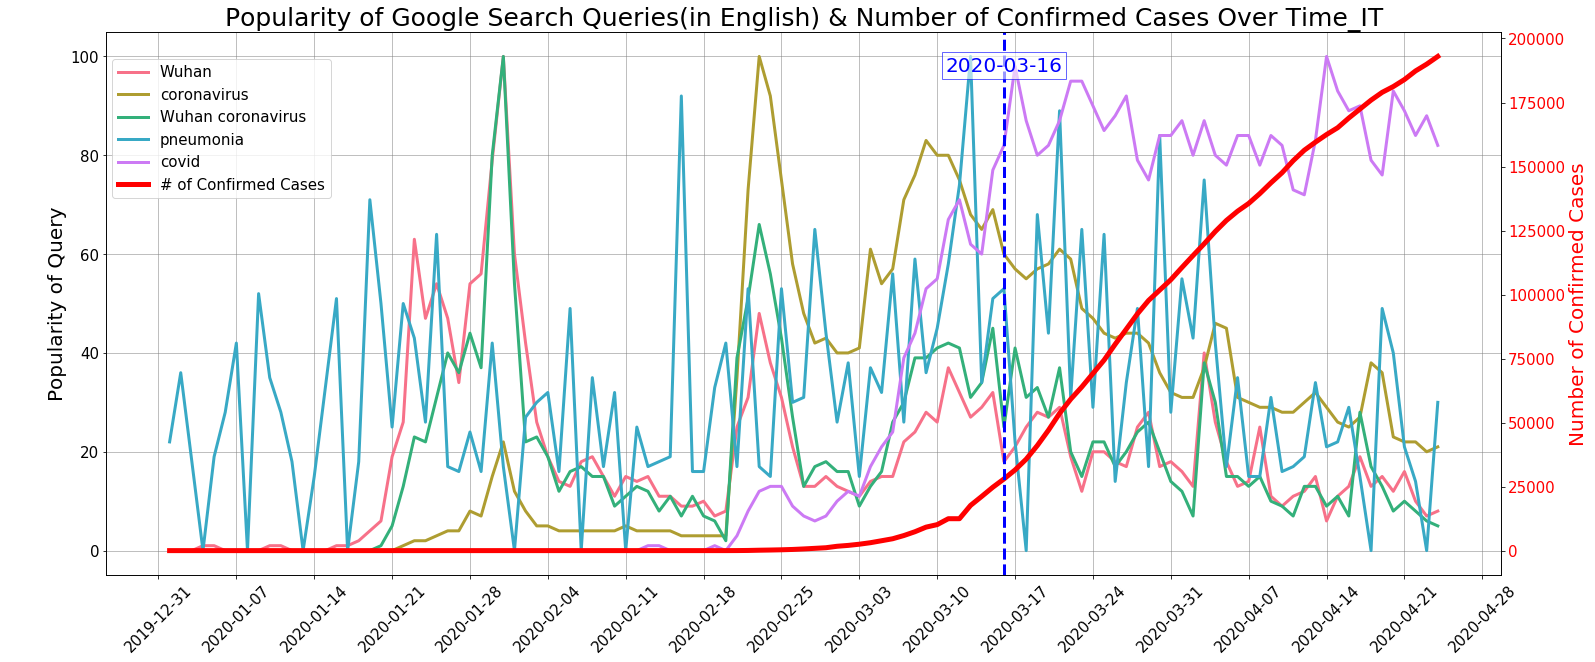

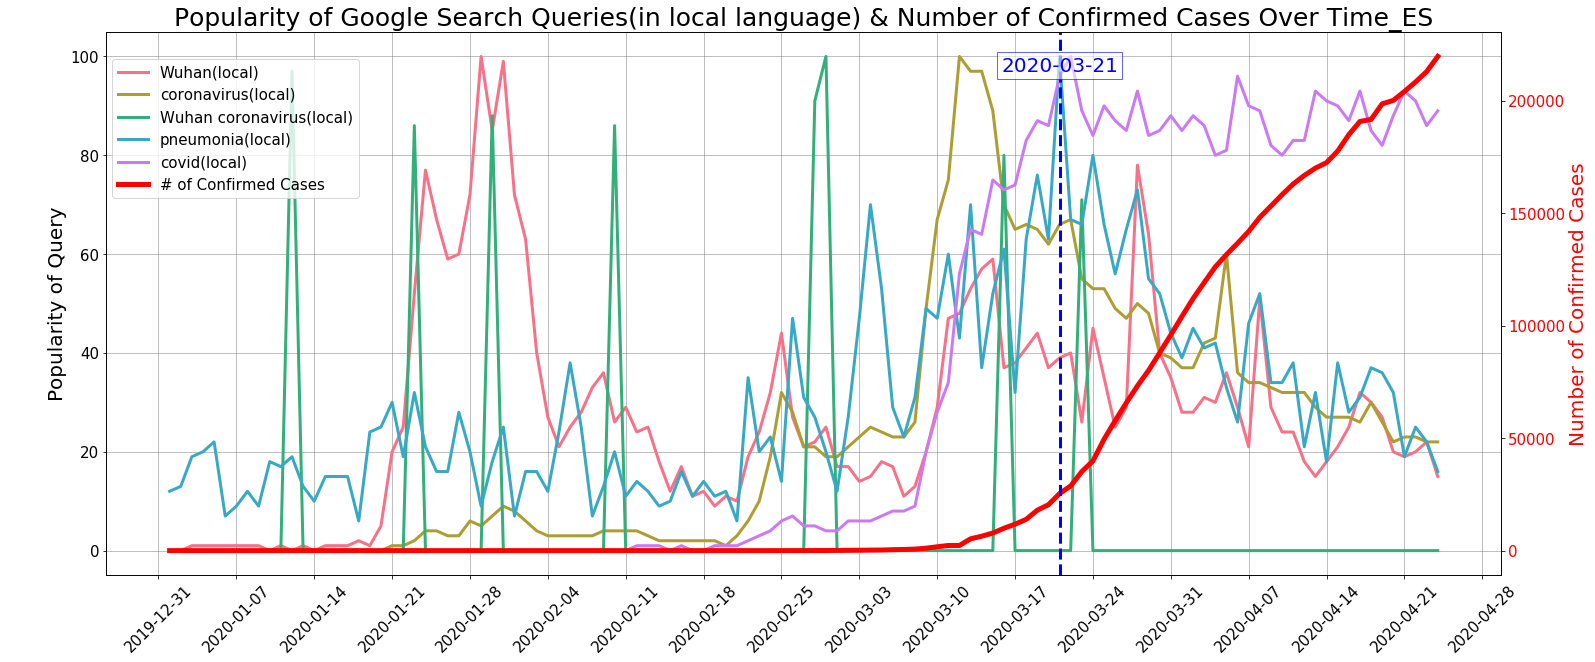

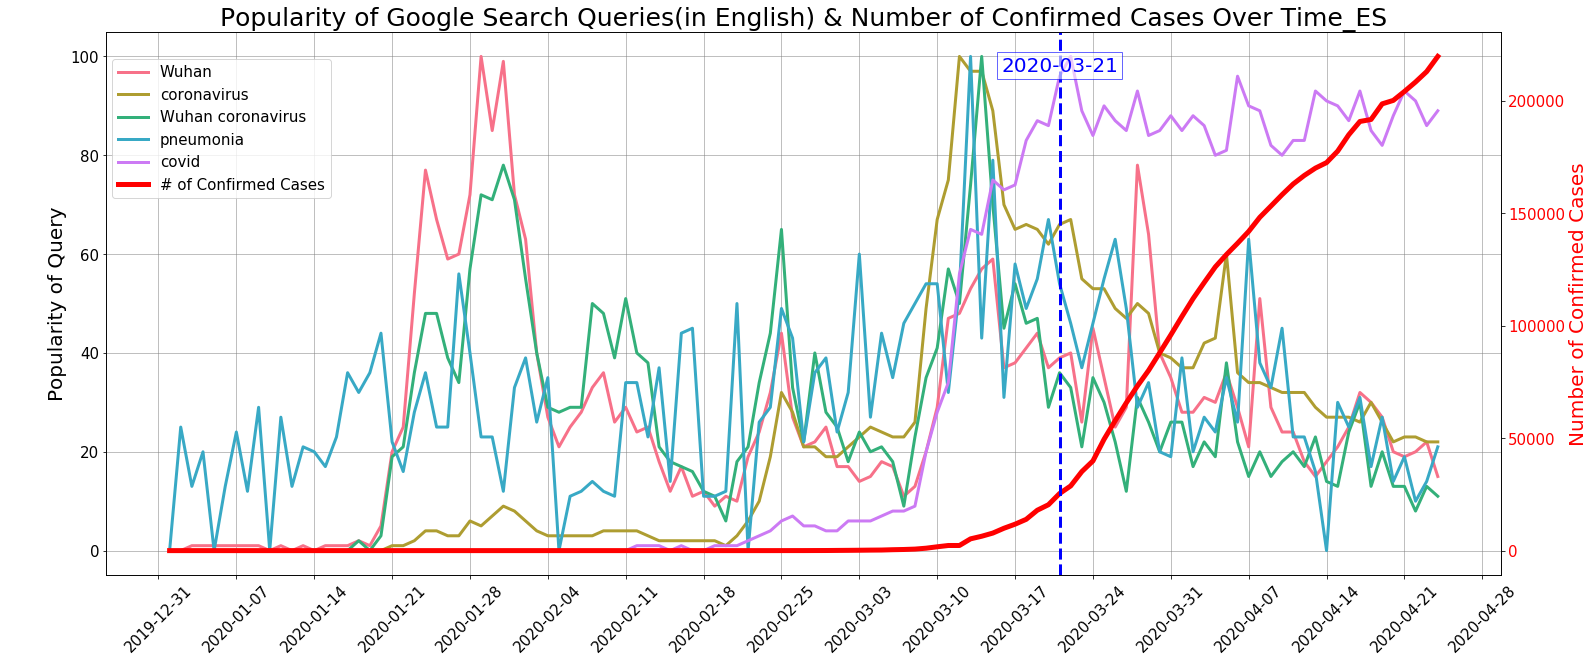

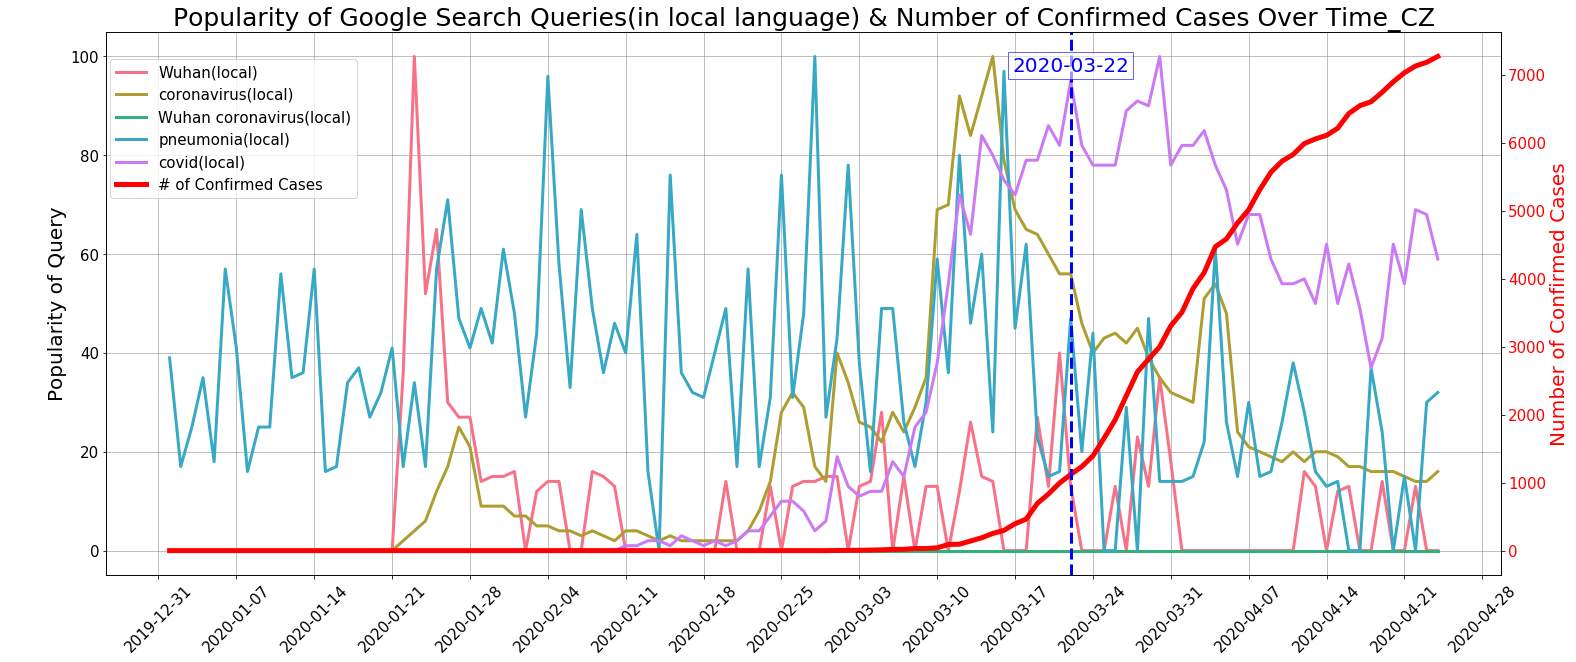

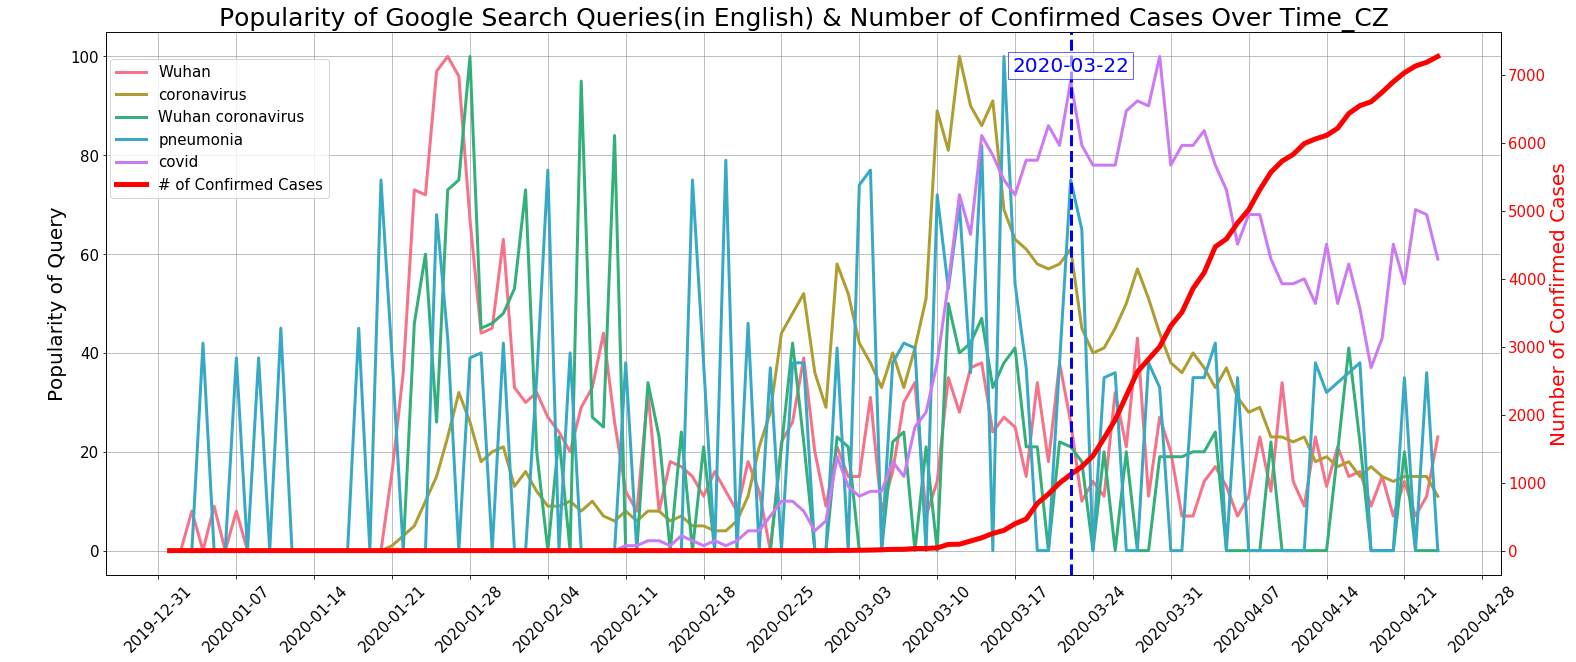

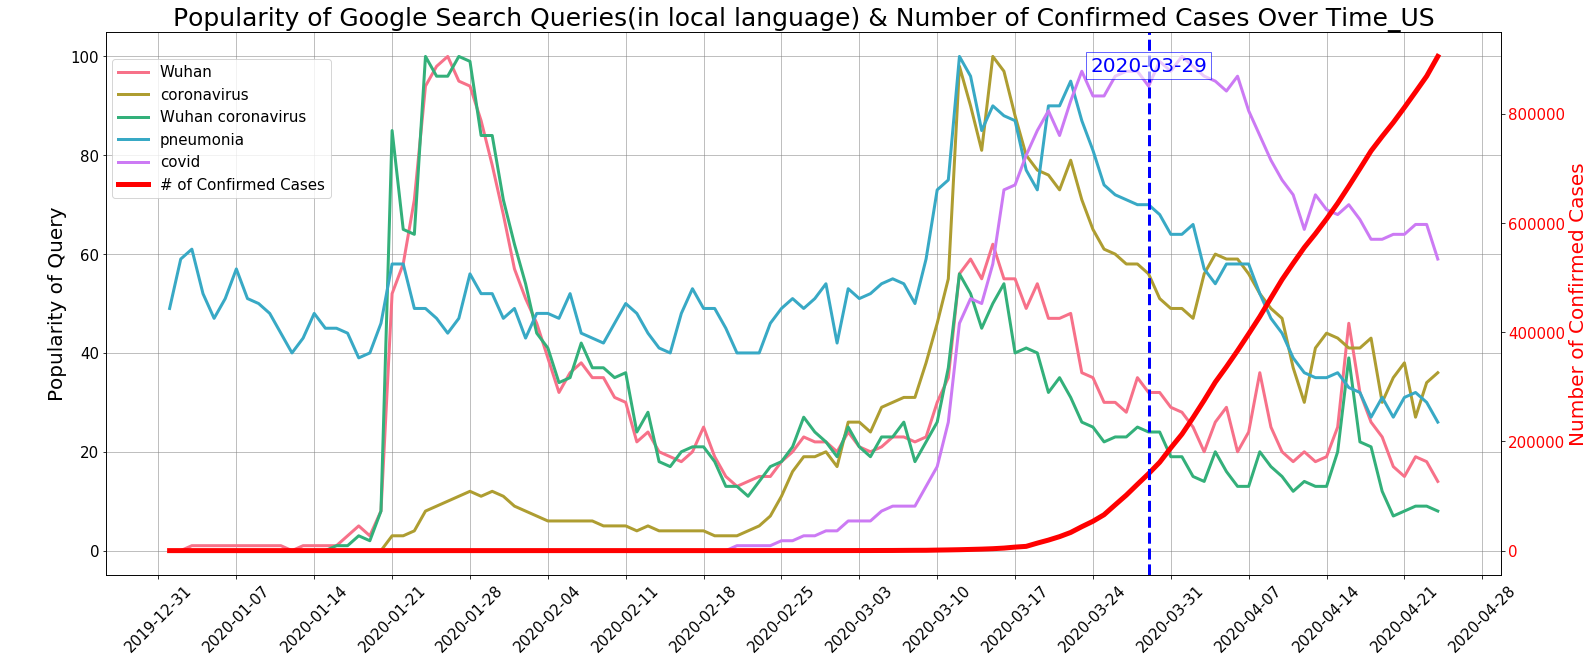

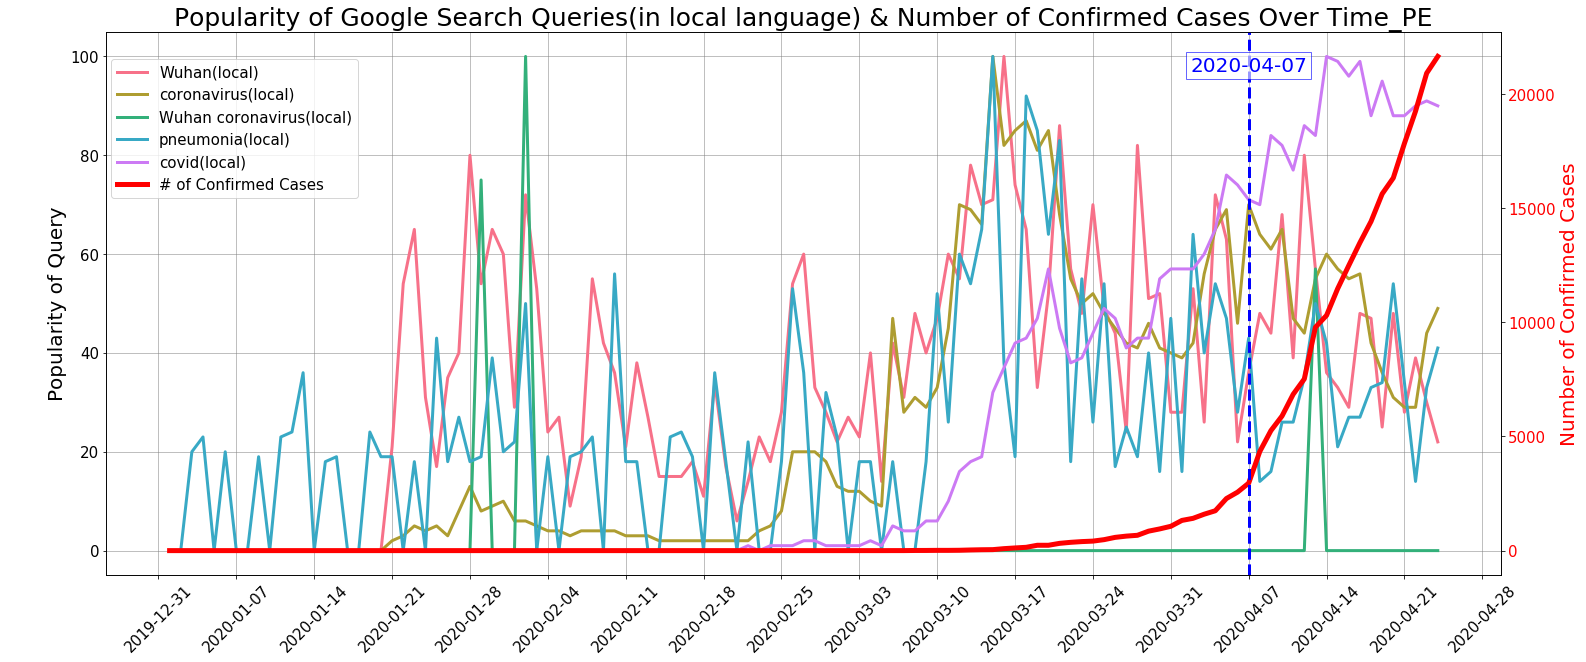

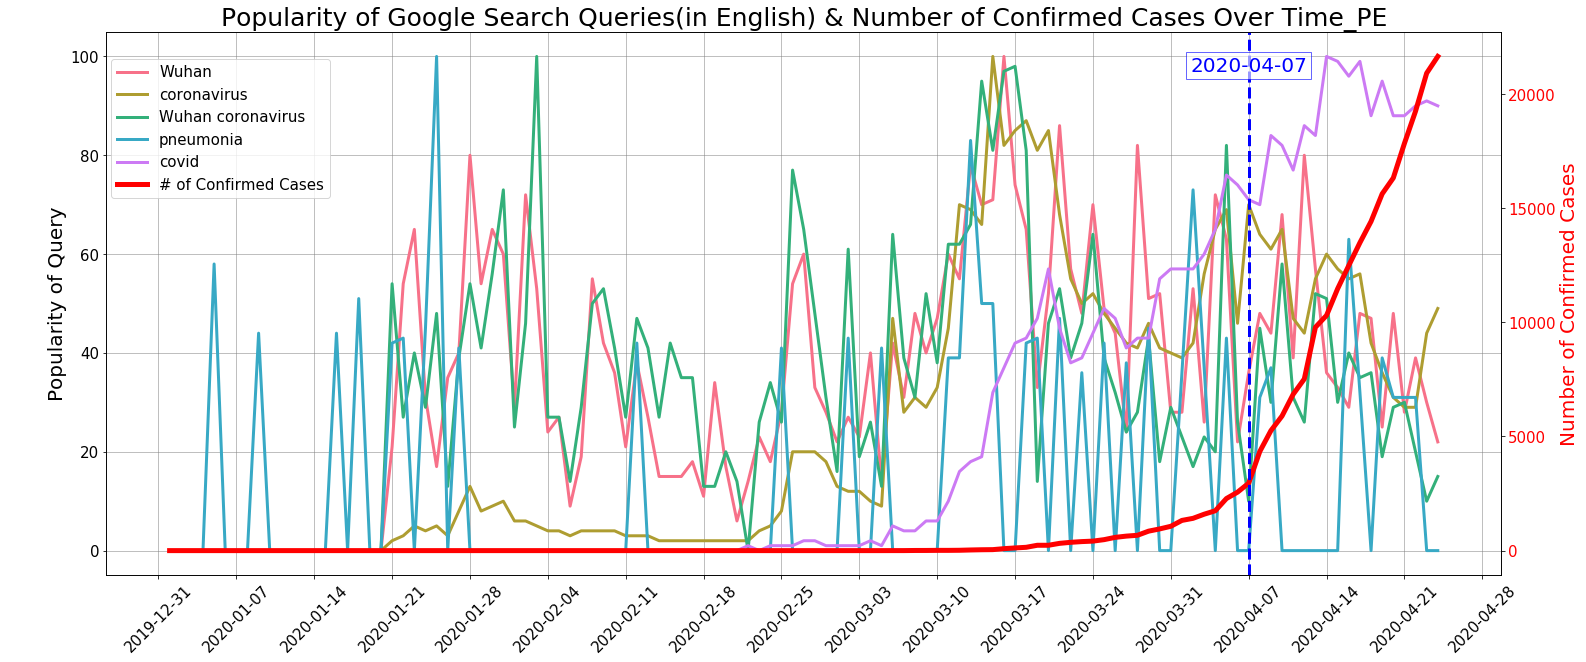

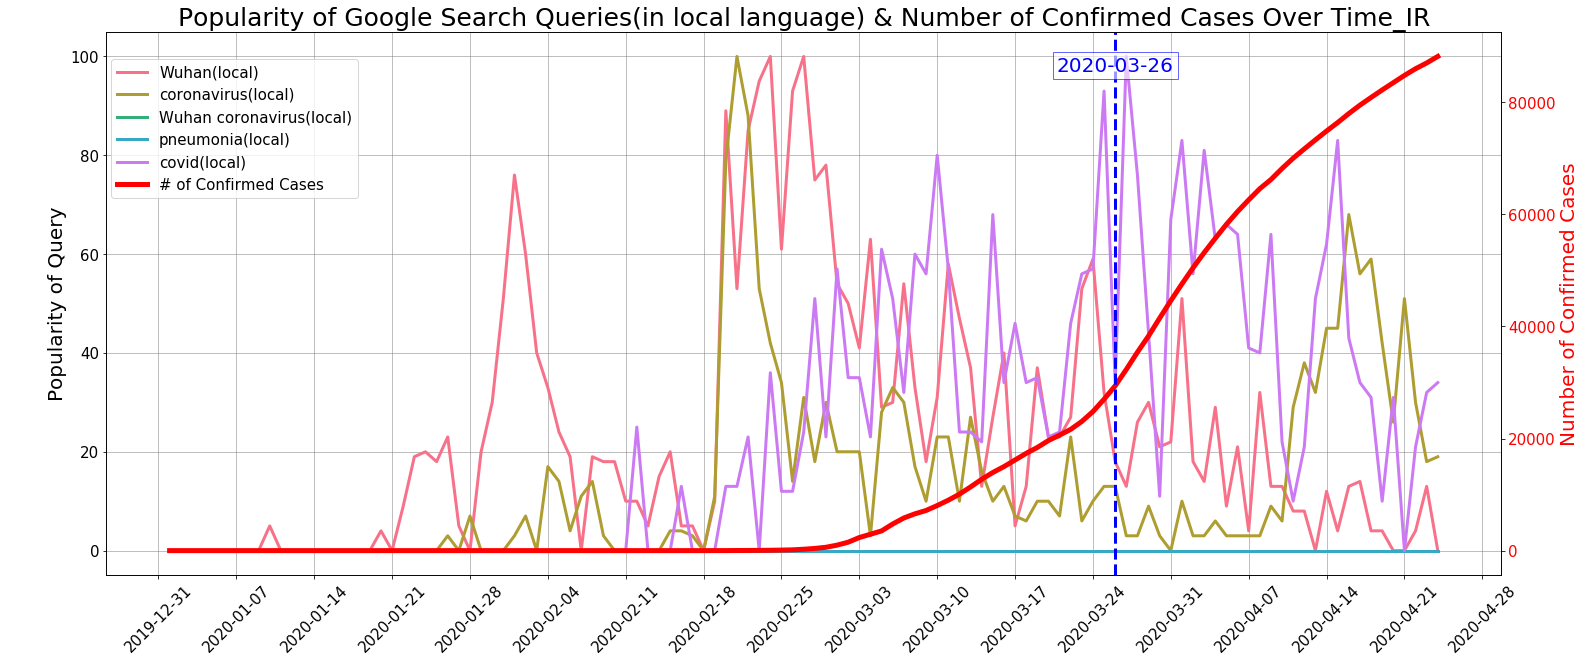

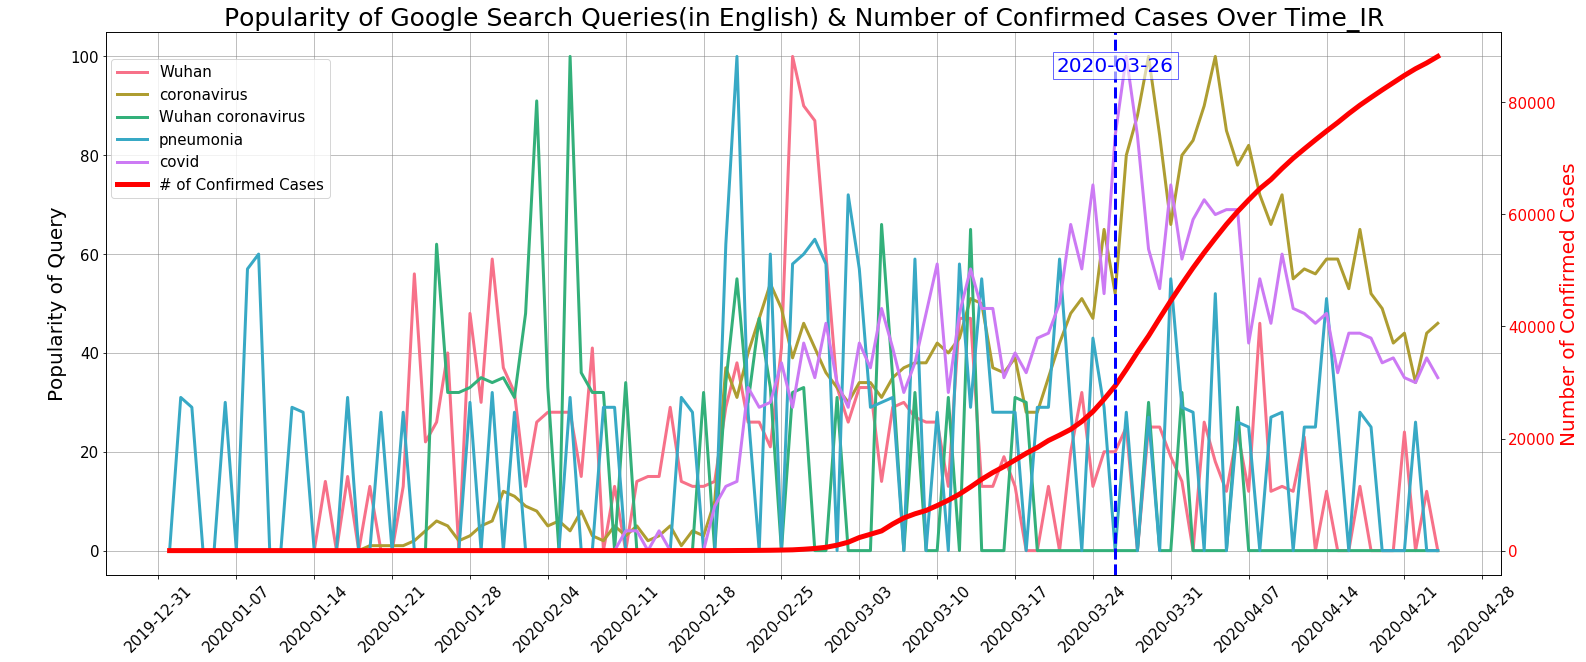

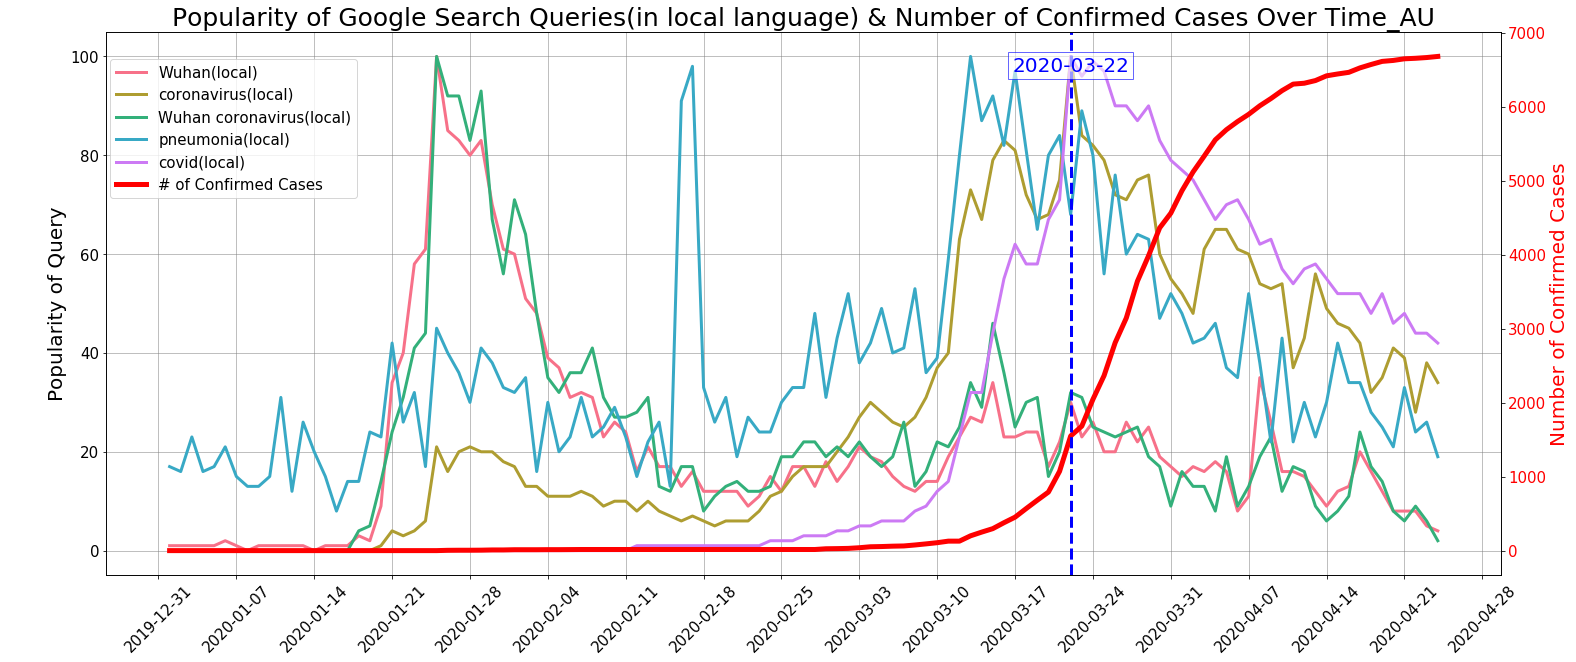

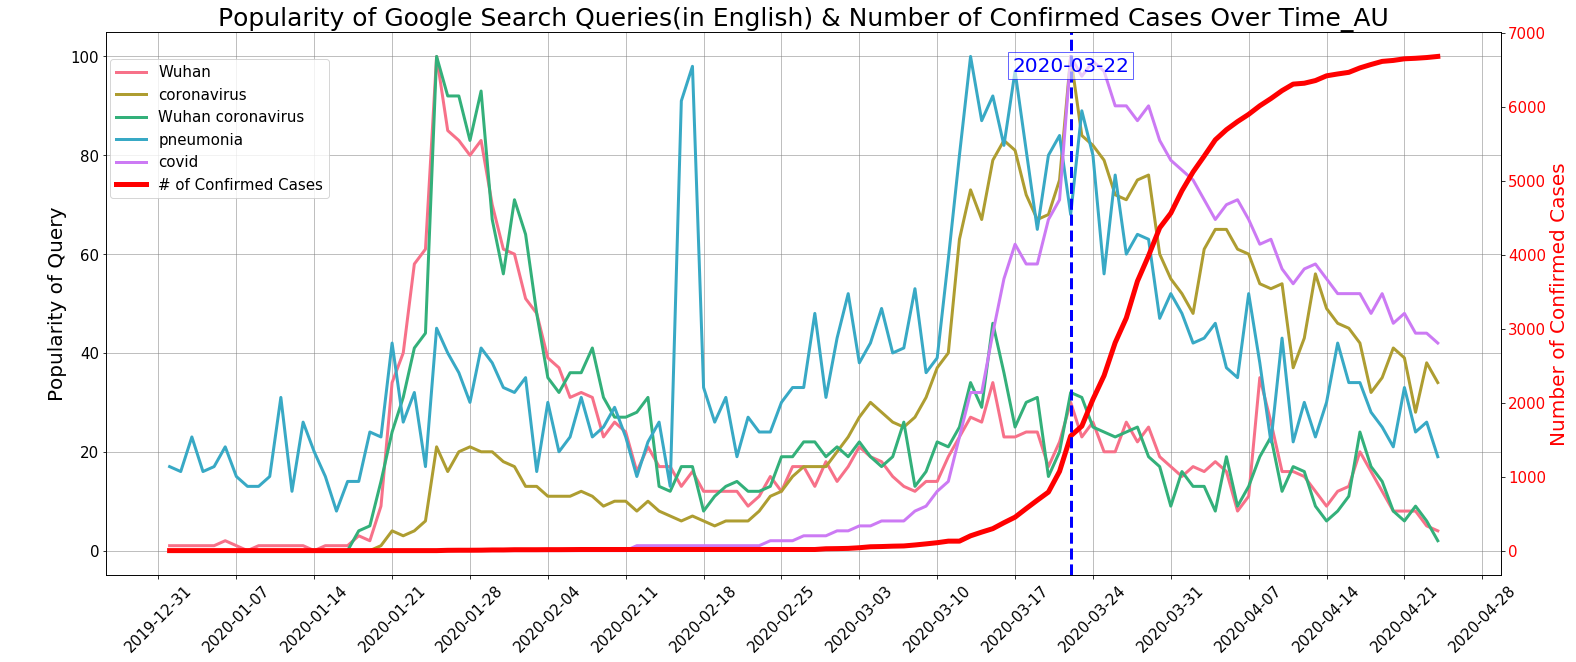

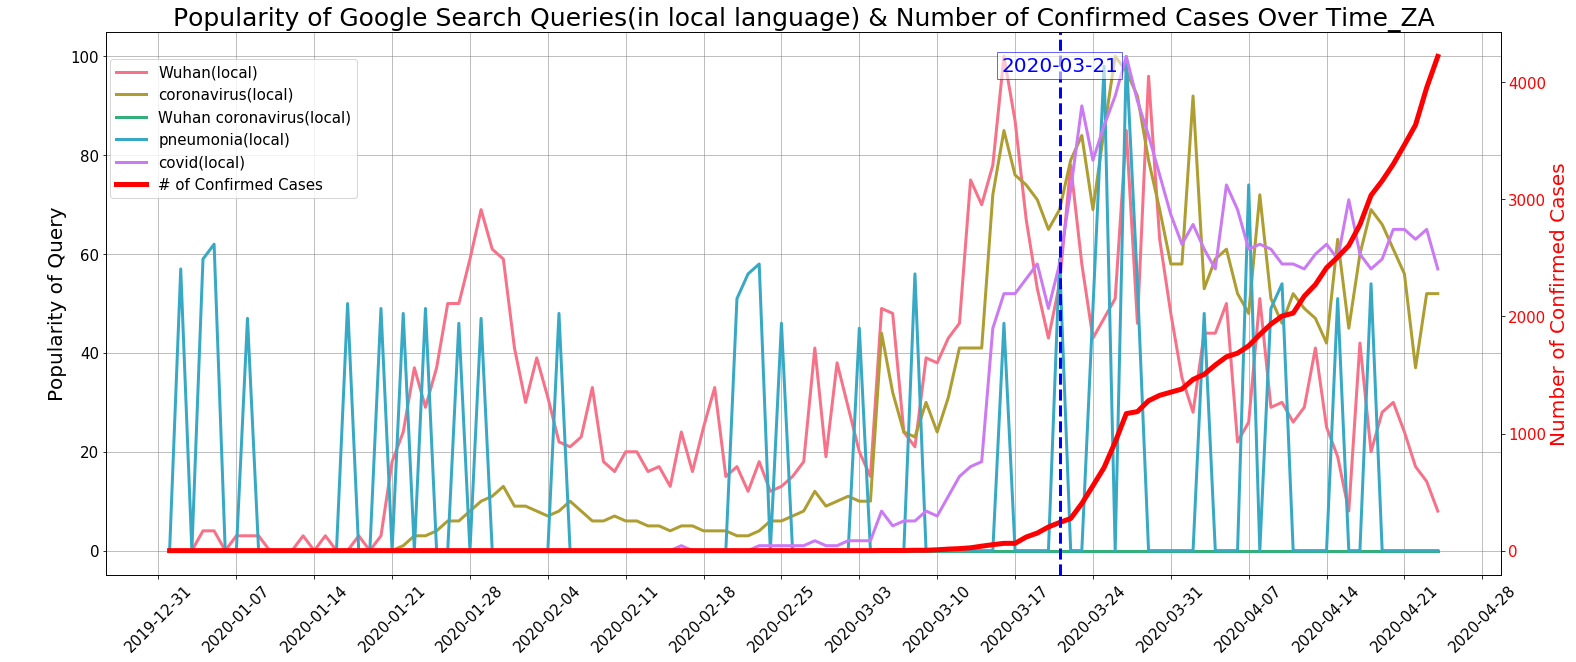

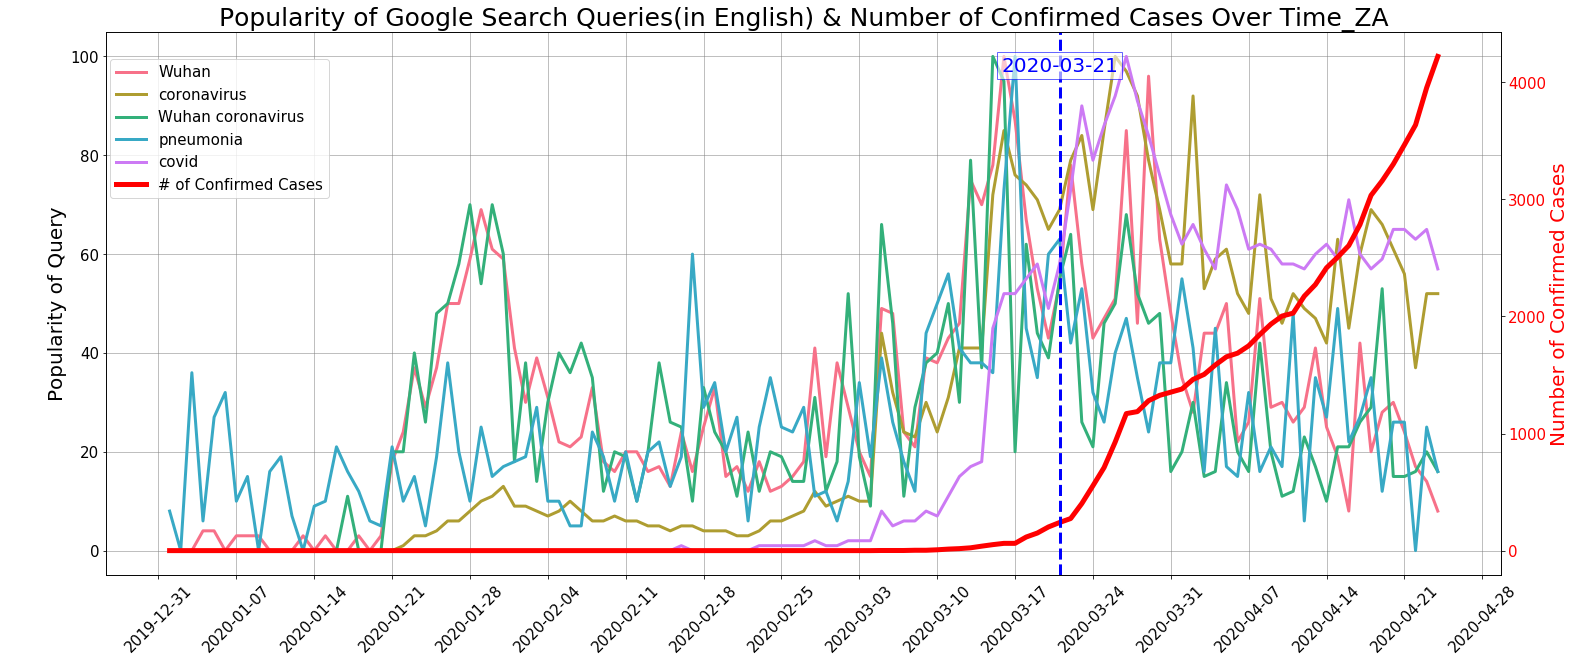

In [49]:
for key in single_google_trends_dict:
    popularity = single_google_trends_dict[key]
    plot_GT_case_trends(popularity, key)
    if key != 'US':
        plot_GT_case_trends(popularity, key, local=False)

### Findings:
### 1. (Multiple) "Wuhan" and "pneumonial" are the most popular keywords searched before the outbreak in TW and KR while "coronavirus" is the most popular in IT, ES, CZ, and US
### 2. (Multi) "coronavirus"(in English) is the most popular search keyword among the others
### 3. (Single)  For local language keyword search, "Wuhan" and "pneumonial" shows an obvious increasing trend in TW and KR while only "Wuhan" shows the similar trend in IT, ES, CZ, and US
### 4. (Single) For English keyword search, "Wuhan" and "Wuhan coronavirus" both show an obvious increasing trend in all the countries
### 5. (Multi & Single) The popularity of "coronavirus"(in local lang) reached the highest point during 2020-03-31 ~ 2020-04-07 in both TW and KR, and reached the local peak in IT, ES, CZ ,and US (English keywords also show similar trends)

### 6. "確診“, ”症狀“, ”疫情“等相關搜尋字串是否考慮列入keyword?

In [18]:
pytrend = TrendReq(hl='en-US', tz=360)
pytrend.build_payload(kw_list=['武漢肺炎'], cat=0, timeframe='2020-01-01 2020-04-19', geo='TW', gprop='')
wuhan_related = pytrend.related_queries()
wuhan_related['武漢肺炎']['top']

query  value
0           武漢 肺炎    100
1        台灣 武漢 肺炎     14
2        武漢 肺炎 疫情     11
3           武漢 疫情     10
4        武漢 肺炎 症狀      8
5        武漢 肺炎 最新      6
6        確診 武漢 肺炎      6
7     武漢 肺炎 最新 疫情      3
8        武漢 肺炎 病徵      3
9        武漢 肺炎 人數      3
10       武漢 肺炎 日本      2
11    台灣 武漢 肺炎 確診      2
12      武漢 肺炎 ptt      2
13     武漢 肺炎 分佈 圖      2
14       武漢 肺炎 口罩      2
15       武漢 肺炎 病毒      2
16       武漢 肺炎 全球      2
17       武漢 肺炎 死亡      2
18    武漢 肺炎 最新 情況      2
19  武漢 肺炎 疫情 分佈 圖      2
20       中國 武漢 肺炎      2
21       美國 武漢 肺炎      2
22       武漢 肺炎 韓國      2
23    武漢 肺炎 疫情 台灣      1
24       武漢 肺炎 英文      1

### Problems:

### 1. When building the country_dict, we need to manually search for the country names used in the dataset and modify accordingly
### --> Maybe use Regex to find similar country names? (ex: South Korea --> Korea, South)

### 2. 台灣的'武漢肺炎'、'新冠肺炎' & 捷克的'武漢肺炎'因搜尋資料不足皆為0

<img src="GT_Results/TW_Wuhan coronavirus(local).png">

<img src="GT_Results/TW_covid(local).png">

<img src="GT_Results/CZ_Wuhan coronavirus(local).png">

### 3. Keywords search results may exist some incorrect data

<img src="GT_Results/TW_Wuhan.png">

<img src="GT_Results/TW_Wuhan coronavirus.png">

<img src="GT_Results/IT_Wuhan coronavirus(local).png">

<img src="GT_Results/CZ_pneumonia(local).png">

# Bar Plot for Awareness Gap Days and Severity

In [50]:
def find_search_peak_date(multi_google_trends_dict, most_popular_keywords_dict):
    search_peak_dict = {}
    for key in multi_google_trends_dict:
        search_peak_dict[key] = multi_google_trends_dict[key][most_popular_keywords_dict[key]].idxmax()
    return(search_peak_dict)
    # results of search peak of single_google_trends_dict will be the same.

In [ ]:
def find_search_peak_date(multi_google_trends_dict, most_popular_keywords_dict, notable_date):
    search_peak_dict = {}
    for key in multi_google_trends_dict:
        notable_date = find_notable_date(confirmed_case)
        if notable_date > multi_google_trends_dict[key][most_popular_keywords_dict[key]].idxmax():
            search_peak_dict[key] = multi_google_trends_dict[key][most_popular_keywords_dict[key]].idxmax()
        else:
            
    return(search_peak_dict)

In [51]:
# If have time... need Modification to automatically get the most popular keywords
most_popular_keywords_dict = {'TW': 'Wuhan(local)',
                              'KR': 'Wuhan(local)',
                              'IT': 'coronavirus(local)',
                              'ES': 'coronavirus(local)',
                              'CZ': 'coronavirus(local)',
                              'US': 'coronavirus',
                              'PE': 'coronavirus(local)',
                              'IR': 'coronavirus(local)',
                              'AU': 'coronavirus(local)',
                              'ZA': 'coronavirus(local)'}

search_peak_dict = find_search_peak_date(multi_google_trends_dict, most_popular_keywords_dict)
# print(search_peak_dict)

In [52]:
notable_date_dict = {}
for key in multi_google_trends_dict:
    notable_date_dict[key] = datetime.strptime(notable_date,'%Y-%m-%d')
# print(notable_date_dict)

In [53]:
aware_period_in_days = {}
for key in multi_google_trends_dict:
    aware_days = datetime.date(notable_date_dict[key]) - datetime.date(search_peak_dict[key])
    aware_period_in_days[key] = aware_days.days
# print(aware_period_in_days)

# Severity Degree- measure in "Confirmed Cases per Million people"

In [54]:
def popul_density_target_country(filename, country_list_popul):
    popul_density = pd.read_csv(filename)
    popul_target = popul_density[popul_density['Country (or dependency)'].isin(country_dict_popul.values())]
    popul_target = popul_target[['Country (or dependency)', 'Density (P/Km?)', 'Population (2020)']]
    return popul_target

In [55]:
filename = 'data/Countries in the world by population (2020).csv'
# noteice that country name here is different from confirmed cases data
country_dict_popul = {'Taiwan*':'Taiwan', 'Korea, South':'South Korea', 'Italy':'Italy', 'Spain':'Spain', 'Czechia':'Czech Republic (Czechia)',
                     'US':'United States', 'Peru':'Peru', 'Iran':'Iran', 'Australia':'Australia', 'South Africa':'South Africa'}
country_list_popul = list(country_dict_popul.keys())
popul_density_target = popul_density_target_country(filename, country_dict_popul)

In [56]:
 popul_density_target.insert(0, "Country/Region", 
                             ["US", "Iran", "Italy", "South Africa", "Korea, South", 
                              "Spain", "Peru", "Australia", "Taiwan*", "Czechia"])

In [57]:
popul_density_with_c = popul_density_target.merge(confirmed_case_target, left_on = "Country/Region", right_on = "Country/Region")

In [58]:
pandemic_severity = popul_density_with_c['4/24/2020'] / popul_density_with_c['Population (2020)'].div(1000000)
popul_density_with_c.insert(4, "Severity", round(pandemic_severity, 2))

In [59]:
# Reference of adding Column with Dictionary values: 
# https://cmdlinetips.com/2018/01/how-to-add-a-new-column-to-using-a-dictionary-in-pandas-data-frame/

In [60]:
popul_density_with_c.insert(4, "Country Code", popul_density_with_c["Country/Region"].map(country_dict))

In [61]:
df_severity = popul_density_with_c[['Country Code', 'Severity']]

In [62]:
df_severity

Country Code  Severity
0           US   2735.20
1           IR   1050.02
2           IT   3192.00
3           ZA     71.15
4           KR    209.05
5           ES   4700.35
6           PE    656.56
7           AU    261.84
8           TW     17.97
9           CZ    679.15

In [63]:
severity_dict = df_severity.set_index('Country Code')['Severity'].to_dict()
# Reference:
# pandas.DataFrame.to_dict: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_dict.html
# set_index: https://stackoverflow.com/questions/52547805/how-to-convert-dataframe-to-dictionary-in-pandas-without-index

<BarContainer object of 10 artists>

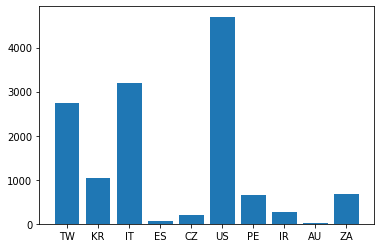

In [64]:
# Severity Degree
plt.bar(aware_period_in_days.keys(), severity_dict.values())

<BarContainer object of 10 artists>

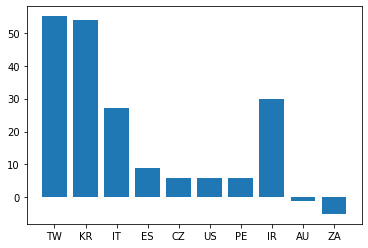

In [65]:
# Awareness Gap Days
plt.bar(aware_period_in_days.keys(), aware_period_in_days.values())

In [66]:
dict_for_hist_plot = {}
for i in aware_period_in_days.keys():
    dict_for_hist_plot[i] = (aware_period_in_days[i], severity_dict[i])

In [67]:
df_for_plot = pd.DataFrame(dict_for_hist_plot).transpose()
df_for_plot.columns = ['Awareness', 'Severity']

In [68]:
df_for_plot

Awareness  Severity
TW       55.0     17.97
KR       54.0    209.05
IT       27.0   3192.00
ES        9.0   4700.35
CZ        6.0    679.15
US        6.0   2735.20
PE        6.0    656.56
IR       30.0   1050.02
AU       -1.0    261.84
ZA       -5.0     71.15

In [69]:
# Reference of Double y-axis:
# https://stackoverflow.com/questions/24183101/pandas-bar-plot-with-two-bars-and-two-y-axis
# https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales

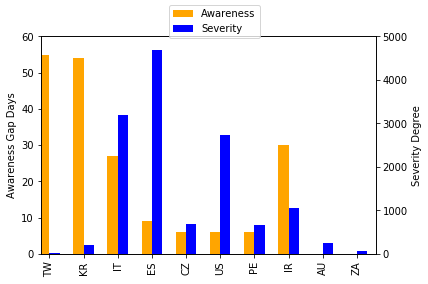

In [70]:
fig = plt.figure()

ax = fig.add_subplot()
ax2 = ax.twinx()

ax.set_ylim(0, 60)
ax2.set_ylim(0, 5000)

width = 0.3

plot_aw = df_for_plot.Awareness.plot(kind = 'bar', color = 'orange', ax = ax, width = width, position = 1)
plot_se = df_for_plot.Severity.plot(kind = 'bar', color = 'blue', ax = ax2, width = width, position = 0)

ax.set_ylabel('Awareness Gap Days')
ax2.set_ylabel('Severity Degree')


fig.legend(loc = 'upper center')
# ax.legend()
# ax2.legend()
plt.show()

# Hypothesis_2

In [71]:
popul_density_with_c

Country/Region   Country (or dependency)  Density (P/Km?)  \
0             US             United States               36   
1           Iran                      Iran               52   
2          Italy                     Italy              206   
3   South Africa              South Africa               49   
4   Korea, South               South Korea              527   
5          Spain                     Spain               94   
6           Peru                      Peru               26   
7      Australia                 Australia                3   
8        Taiwan*                    Taiwan              673   
9        Czechia  Czech Republic (Czechia)              139   

   Population (2020) Country Code  Severity  1/22/2020  1/23/2020  1/24/2020  \
0          331002651           US   2735.20          1          1          2   
1           83992949           IR   1050.02          0          0          0   
2           60461826           IT   3192.00          0          0          0   
3           59308690           ZA     71.15          0          0          0   
4           51269185           KR    209.05          1          1          2   
5           46754778           ES   4700.35          0          0          0   
6           32971854           PE    656.56          0          0          0   
7           25499884           AU    261.84          0          0          0   
8           23816775           TW     17.97          1          1          3   
9           10708981           CZ    679.15          0          0          0   

   1/25/2020  ...  4/17/2020  4/18/2020  4/19/2020  4/20/2020  4/21/2020  \
0          2  ...     699706     732197     758809     784326     811865   
1          0  ...      79494      80868      82211      83505      84802   
2          0  ...     172434     175925     178972     181228     183957   
3          0  ...       2783       3034       3158       3300       3465   
4          2  ...      10635      10653      10661      10674      10683   
5          0  ...     190839     191726     198674     200210     204178   
6          0  ...      13489      14420      15628      16325      17837   
7          0  ...       6522       6568       6610       6623       6645   
8          3  ...        395        398        420        422        425   
9          0  ...       6549       6606       6746       6900       7033   

   4/22/2020  4/23/2020  4/24/2020          Name  Code  
0     840351     869170     905358            US    US  
1      85996      87026      88194          Iran    IR  
2     187327     189973     192994         Italy    IT  
3       3635       3953       4220  South Africa    ZA  
4      10694      10708      10718  Korea, South    KR  
5     208389     213024     219764         Spain    ES  
6      19250      20914      21648          Peru    PE  
7       6652       6662       6677     Australia    AU  
8        426        427        428       Taiwan*    TW  
9       7132       7187       7273       Czechia    CZ  

[10 rows x 102 columns]

In [31]:
# popul_density_with_c.plot.scatter(x = 'Density (P/Km?)', y = 'Severity')

In [28]:
# Reference of Scatterplot with annotation on each data point:
# https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point

In [72]:
x = list(popul_density_with_c['Density (P/Km?)'])
y = list(popul_density_with_c['Severity'])
c = list(popul_density_with_c['Country Code'])

Text(0, 0.5, 'Severity Degree')

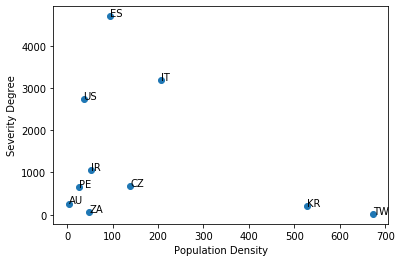

In [73]:
fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(c):
    ax.annotate(txt, (x[i], y[i]))
    
plt.xlabel('Population Density')
plt.ylabel('Severity Degree')